In [1]:
from __future__ import division
import pickle
import os
import types
import random
import uuid
import math
from copy import deepcopy as copy
import logging


import gym
from gym import spaces
from gym.envs.classic_control import rendering
import numpy as np
import tensorflow as tf
from scipy.misc import logsumexp
from baselines import deepq
import baselines.common.tf_util as U




In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [4]:
from nn_dynamics import MPCController

In [5]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline

In [6]:
import matplotlib as mpl
mpl.rc('savefig', dpi=300)
mpl.rc('text', usetex=False)

In [7]:
# logger = logging.getLogger('root')
# print(logger.hasHandlers())
# assert len(logger.handlers) == 1
# handler = logger.handlers[0]
# handler.setLevel(logging.WARNING)

In [8]:
data_dir = os.path.join('data', '4.0')

In [9]:
sess = tf.Session()

create envs, pilot policies

In [10]:
throttle_mag = 0.75
def disc_to_cont(action):
  if type(action) == np.ndarray:
    return action
  # main engine
  if action < 3:
    m = -throttle_mag
  elif action < 6:
    m = throttle_mag
  else:
    raise ValueError
  # steering
  if action % 3 == 0:
    s = -throttle_mag
  elif action % 3 == 1:
    s = 0
  else:
    s = throttle_mag
  return np.array([m, s])

In [11]:
n_act_dim = 6
n_obs_dim = 9

In [12]:
max_ep_len = 1000

In [13]:
fps = 40

grid search

In [14]:
train_goals = np.arange(1, 9, 1).astype(int)
n_train_tasks = train_goals.size

In [15]:
def make_lander_env(fps=fps, goal=None):
  env = gym.make('LunarLanderContinuous-v2')
  env.unwrapped.goal = goal
  env.action_space = spaces.Discrete(n_act_dim)
  env.unwrapped._step_orig = env.unwrapped.step
  def step(self, action):
    obs, r, done, info = self._step_orig(disc_to_cont(action))
    return obs, r, done, info
  env.unwrapped.step = types.MethodType(step, env.unwrapped)
  env.unwrapped.fps = fps
  return env

In [16]:
# train_newton_envs = [make_lander_env(fps=fast_fps, goal=goal) for goal in train_goals]
train_envs = [make_lander_env(fps=fps, goal=goal) for goal in train_goals]

In [17]:
 def run_ep(policy, env, max_ep_len=max_ep_len, render=False, task_idx=None):
  obs = env.reset()
  done = False
  totalr = 0.
  prev_obs = obs
  rollout = []
  for step_idx in range(max_ep_len+1):
    if done:
      break
    action = policy(obs)
    obs, r, done, info = env.step(action)
    rollout.append((prev_obs, action, r, obs, float(done), task_idx))
    prev_obs = obs
    if render:
      env.render()
    totalr += r
  return rollout

train agent with soft dqn

In [18]:
train_env = make_lander_env(fps=fps)

In [19]:
n_training_episodes = 800
load_pretrained_pilot = True

In [20]:
make_q_func = lambda: deepq.models.mlp([64, 64])
dqn_learn_kwargs = {
  'lr': 1e-3,
  'target_network_update_freq': 3000,
  'print_freq': 100,
  'max_timesteps': max_ep_len * (1 if load_pretrained_pilot else n_training_episodes)
}

In [21]:
with open(os.path.join(data_dir, 'dqn_pilot_scope.pkl'), 'rb') as f:
  dqn_pilot_scope = pickle.load(f)

In [22]:
# dqn_pilot_scope = str(uuid.uuid4())

In [23]:
train_env.action_space #.contains(np.int64(1))

Discrete(6)

In [24]:
raw_dqn_pilot_policy, _ = deepq.learn(
  train_env,
  q_func=make_q_func(),
  scope=dqn_pilot_scope,
  **dqn_learn_kwargs
)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# with open(os.path.join(data_dir, 'dqn_pilot_scope.pkl'), 'wb') as f:
#   pickle.dump(dqn_pilot_scope, f, pickle.HIGHEST_PROTOCOL)

In [26]:
dqn_pilot_path = os.path.join(data_dir, 'dqn_pilot.tf')

In [27]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

In [28]:
def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [29]:
# save_tf_vars(U.get_session(), dqn_pilot_scope, dqn_pilot_path)

In [30]:
load_tf_vars(U.get_session(), dqn_pilot_scope, dqn_pilot_path)

INFO:tensorflow:Restoring parameters from data/4.0/dqn_pilot.tf


In [31]:
VIEWPORT_W = 600
VIEWPORT_H = 400
SCALE = 30.0
W = VIEWPORT_W/SCALE
H = VIEWPORT_H/SCALE
CHUNKS = 11
chunk_x = [W/(CHUNKS-1)*i for i in range(CHUNKS)]
helipad_xs = [(chunk_x[goal-1]+chunk_x[goal+1])/2 for goal in train_goals]
train_goal_obses = [(helipad_x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2) for helipad_x in helipad_xs]

In [32]:
temperature = 1
def make_pilot_policy(train_task_idx):
  goal_obs = train_goal_obses[train_task_idx]
  def pilot_policy(obs):
    my_obs = copy(obs)
    my_obs[8] = goal_obs
    with tf.variable_scope(dqn_pilot_scope, reuse=None):
      return raw_dqn_pilot_policy._act(my_obs[None, :], temperature=temperature)[0]
  return pilot_policy

In [33]:
pilot_policies = [make_pilot_policy(train_task_idx) for train_task_idx in range(n_train_tasks)]

In [34]:
def make_pilot_policy(train_task_idx):
  return pilot_policies[train_task_idx]

sanity-check envs, agents

In [35]:
# train_task_idx = 0

In [36]:
# run_ep(pilot_policies[train_task_idx], train_envs[train_task_idx], render=True)

In [37]:
# train_envs[train_task_idx].close()

In [38]:
# run_ep(pilot_policies[train_task_idx], train_newton_envs[train_task_idx], render=True)

In [39]:
# train_newton_envs[train_task_idx].close()

fit internal dynamics model

In [40]:
n_train_rollouts_per_env = 1000

In [41]:
# demo_rollouts = [[run_ep(pilot_policies[train_task_idx], newton_env, render=False, task_idx=train_task_idx)          
#                   for _ in range(n_train_rollouts_per_env)]
#                  for train_task_idx, newton_env in enumerate(train_newton_envs)]

In [42]:
# with open(os.path.join(data_dir, 'pilot_policy_demo_rollouts.pkl'), 'wb') as f:
#   pickle.dump(demo_rollouts, f, pickle.HIGHEST_PROTOCOL)

In [43]:
# demo_rollouts_path = os.path.join('data', '5.1-lander-newton', 'sid_pilot_policy_demo_rollouts.pkl')
demo_rollouts_path = os.path.join(data_dir, 'pilot_policy_demo_rollouts.pkl')

In [44]:
with open(demo_rollouts_path, 'rb') as f:
  demo_rollouts = pickle.load(f)

demo_rollouts = demo_rollouts[:len(train_goals)]

In [45]:
for demo in demo_rollouts:
    print(demo[0])

[(array([ 0.0032814 ,  0.92939788,  0.33235225, -0.7476995 , -0.0037955 ,
       -0.07528286,  0.        ,  0.        , -0.8       ]), 3, 3.151349939014491, array([ 0.00660982,  0.91869279,  0.33445528, -0.71367693, -0.00539582,
       -0.03200971,  0.        ,  0.        , -0.8       ]), 0.0, 0), (array([ 0.00660982,  0.91869279,  0.33445528, -0.71367693, -0.00539582,
       -0.03200971,  0.        ,  0.        , -0.8       ]), 0, -2.8631122602854395, array([ 9.87434387e-03,  9.07362181e-01,  3.26439381e-01, -7.55376418e-01,
       -5.38633112e-03,  1.89788276e-04,  0.00000000e+00,  0.00000000e+00,
       -8.00000000e-01]), 0.0, 0), (array([ 9.87434387e-03,  9.07362181e-01,  3.26439381e-01, -7.55376418e-01,
       -5.38633112e-03,  1.89788276e-04,  0.00000000e+00,  0.00000000e+00,
       -8.00000000e-01]), 0, -2.613672729299757, array([ 0.01306028,  0.89540768,  0.31659359, -0.79696234, -0.00340276,
        0.03967598,  0.        ,  0.        , -0.8       ]), 0.0, 0), (array([ 0.01306

[(array([-0.00967913,  0.93939906, -0.98039931, -0.08099317,  0.01122241,
        0.22207515,  0.        ,  0.        ,  0.6       ]), 5, -0.8500482062526407, array([-0.01933107,  0.93862248, -0.97433418, -0.05186737,  0.02026287,
        0.18083085,  0.        ,  0.        ,  0.6       ]), 0.0, 7), (array([-0.01933107,  0.93862248, -0.97433418, -0.05186737,  0.02026287,
        0.18083085,  0.        ,  0.        ,  0.6       ]), 2, -0.7024247026680177, array([-0.02891998,  0.93722182, -0.96641546, -0.09349178,  0.02770265,
        0.1488131 ,  0.        ,  0.        ,  0.6       ]), 0.0, 7), (array([-0.02891998,  0.93722182, -0.96641546, -0.09349178,  0.02770265,
        0.1488131 ,  0.        ,  0.        ,  0.6       ]), 2, -0.6757083894157381, array([-0.03844576,  0.93519822, -0.95848793, -0.13502999,  0.03354567,
        0.11687401,  0.        ,  0.        ,  0.6       ]), 0.0, 7), (array([-0.03844576,  0.93519822, -0.95848793, -0.13502999,  0.03354567,
        0.11687401,  0.   

In [46]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
  ):
  out = input_placeholder
  with tf.variable_scope(scope, reuse=reuse):
    for _ in range(n_layers):
      out = tf.layers.dense(out, size, activation=activation)
    out = tf.layers.dense(out, output_size, activation=output_activation)
  return out

In [47]:
n_obs_feats = n_obs_dim
featurize_obs = lambda s: s
n_act_feats = 2
featurize_act = lambda a: [disc_to_cont(act) for act in a]

In [48]:
def vectorize_rollouts(rollouts):
  obs = [[] for _ in range(n_train_tasks)]
  actions = [[] for _ in range(n_train_tasks)]
  next_obs = [[] for _ in range(n_train_tasks)]
  for task_idx, task_rollouts in enumerate(rollouts):
    for task_rollout in task_rollouts:
      more_obs, more_actions, _, more_next_obs = list(zip(*task_rollout))[:4]
      obs[task_idx].extend([featurize_obs(s) for s in more_obs])
      actions[task_idx].extend(more_actions)
      next_obs[task_idx].extend([featurize_obs(s) for s in more_next_obs])
  l = min(len(x) for x in obs)
  idxes = [random.sample(list(range(len(x))), l) for x in obs]
  f = lambda x: np.array(x[1])[idxes[x[0]]]
  obs = np.array(list(map(f, enumerate(obs))))
  actions = np.array(list(map(f, enumerate(actions))))
  action_feats = np.array([featurize_act(a) for a in actions])
  next_obs = np.array(list(map(f, enumerate(next_obs))))

  return obs, actions, action_feats, next_obs

In [49]:
demo_obs = None
demo_actions = None
demo_act_feats = None
demo_next_obs = None
demo_task_idxes = None
train_demo_example_idxes = None
val_demo_batch = None

In [50]:
def process_demo_rollouts(demo_rollouts):
  global demo_obs
  global demo_actions
  global demo_act_feats
  global demo_next_obs
  global demo_task_idxes
  global train_demo_example_idxes
  global val_demo_batch

  
  demo_obs, demo_actions, demo_act_feats, demo_next_obs = vectorize_rollouts(demo_rollouts)
  demo_example_idxes = list(range(demo_obs.shape[1]))
  
  random.shuffle(demo_example_idxes)
  n_train_demo_examples = int(0.9 * len(demo_example_idxes))
  train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
  val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
  val_demo_batch = (demo_obs[:, val_demo_example_idxes], demo_actions[:, val_demo_example_idxes],
        demo_act_feats[:, val_demo_example_idxes], demo_next_obs[:, val_demo_example_idxes])

In [51]:
process_demo_rollouts(demo_rollouts)

In [52]:
def sample_batch(size):
  idxes = random.sample(train_demo_example_idxes, size)
  demo_batch = demo_obs[:, idxes], demo_actions[:, idxes], demo_act_feats[:, idxes], demo_next_obs[:, idxes]
  return demo_batch

In [53]:
gamma = 0.99
iterations = 100000
learning_rate = 1e-2
batch_size = 512 // n_train_tasks
sq_td_err_penalty = 1e-3
trans_err_penalty = 1e0


q_n_layers = 1
q_layer_size = 32
q_activation = tf.nn.relu
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 32
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 100

In [54]:
# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invdyn_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#   pickle.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#   pickle.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invdyn_scope.pkl'), 'wb') as f:
#   pickle.dump(invdyn_scope, f)

In [55]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
  im_scope = pickle.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
  q_scope = pickle.load(f)

with open(os.path.join(data_dir, 'invdyn_scope.pkl'), 'rb') as f:
  invdyn_scope = pickle.load(f)

In [56]:
demo_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats], name="dot")
demo_act_t_ph = tf.placeholder(tf.int32, [n_train_tasks, None], name="dat")
demo_act_t_feats_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_act_feats], name="datf")
demo_next_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats], name="dnot")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")


constraint_obs_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_obs_feats], name="cot")
constraint_act_t_ph = tf.placeholder(tf.int32, [n_train_tasks, None], name="cat")
constraint_act_t_feats_ph = tf.placeholder(tf.float32, [n_train_tasks, None, n_act_feats], name="catf")
constraint_rew_t_ph = tf.placeholder(tf.float32, [n_train_tasks, None], name="crt")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [57]:
demo_batch_idxes = tf.reshape(
  tf.range(0, demo_batch_size_ph, 1), 
  [demo_batch_size_ph, 1])

extract_task = lambda x, i: tf.squeeze(tf.gather(x, tf.convert_to_tensor(
  [i], dtype=tf.int32)), axis=[0]) 

demo_q_t = tf.stack([tf.gather_nd(
  build_mlp(
    extract_task(demo_obs_t_ph, train_task_idx),
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation
  ), 
  tf.concat([
    demo_batch_idxes, 
    tf.expand_dims(extract_task(demo_act_t_ph, train_task_idx), 1)], axis=1)
) for train_task_idx in range(n_train_tasks)], axis=0)

demo_v_t = tf.reduce_logsumexp(
  tf.stack([build_mlp(
    extract_task(demo_obs_t_ph, train_task_idx),
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True
  ) for train_task_idx in range(n_train_tasks)], axis=0),
  axis=2)

act_log_likelihoods = demo_q_t - demo_v_t

In [58]:
neg_avg_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [59]:
pred_next_obs = build_mlp(
  tf.concat((demo_obs_t_ph, demo_act_t_feats_ph), axis=2),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

In [60]:
demo_next_obs_t_reshaped = tf.reshape(
  demo_next_obs_t_ph, [n_train_tasks, demo_batch_size_ph, n_obs_feats])

demo_pred_next_obs_t_reshaped = tf.reshape(
    pred_next_obs, [n_train_tasks, demo_batch_size_ph, n_obs_feats])

In [61]:
trans_err = pred_next_obs - demo_next_obs_t_ph

In [62]:
trans_loss = tf.reduce_mean(trans_err**2)

In [63]:
# Predicted constraint next state given inv dyns
constraint_obs_tp1 = tf.reshape(build_mlp(
  tf.concat((constraint_obs_t_ph, constraint_act_t_feats_ph), axis=2),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True), [n_train_tasks, constraint_batch_size_ph, n_obs_feats])

In [64]:
q_tp1 = tf.stack([build_mlp(
    extract_task(tf.stop_gradient(constraint_obs_tp1), train_task_idx), 
    n_act_dim, q_scope+'-'+str(train_task_idx),
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation, 
    reuse=True) for train_task_idx in range(n_train_tasks)], axis=0)
v_tp1 = tf.reduce_logsumexp(q_tp1, axis=2)

In [65]:
target_t = constraint_rew_t_ph + gamma * v_tp1

In [66]:
constraint_batch_idxes = tf.reshape(
  tf.range(0, constraint_batch_size_ph, 1), 
  [constraint_batch_size_ph, 1])

# Sampled constraint state q-vals
q_t = tf.stack([tf.gather_nd(
  build_mlp(
    extract_task(constraint_obs_t_ph, train_task_idx), 
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation, 
    reuse=True
  ), 
  tf.concat([
    constraint_batch_idxes, 
    tf.expand_dims(extract_task(constraint_act_t_ph, train_task_idx), 1)], axis=1)
) for train_task_idx in range(n_train_tasks)], axis=0)

In [67]:
# Bellman errors
td_err = q_t - target_t

In [68]:
sq_td_err = tf.reduce_mean(td_err**2)

In [69]:
loss = neg_avg_log_likelihood + sq_td_err_penalty * sq_td_err + trans_err_penalty * trans_loss

In [70]:
full_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
trans_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(trans_loss)

In [71]:
def sample_constraints(new_val=True):
  
  constraint_rollouts = [[] for _ in range(n_train_tasks)]
  
  for train_task_idx in range(n_train_tasks):
    rollouts = [[] for _ in range(n_constraint_rollouts_per_env)]
    envs = [make_lander_env(
      fps=fps, goal=train_goals[train_task_idx]) for _ in range(
      n_constraint_rollouts_per_env)]
    obses = np.array([env.reset() for env in envs])
    dones = [False for _ in envs]
    prev_obses = obses
    for step_idx in range(max_ep_len+1):
      not_done_idxes = [i for i, done in enumerate(dones) if not done]
      batch_size = len(not_done_idxes)
      if batch_size == 0:
        break
      actions = np.random.choice(n_act_dim, batch_size)
      for i, env_idx in enumerate(not_done_idxes):
        env = envs[env_idx]
        action = actions[i]
        obs, r, done, info = env.step(action)
        obses[env_idx] = obs
        dones[env_idx] = done
        rollouts[env_idx].append((
          prev_obses[env_idx], action, r))
      prev_obses = copy(obses)
    constraint_rollouts[train_task_idx].extend([r for r in rollouts if r != []])

  size = min(sum(len(r) for r in rollouts) for rollouts in constraint_rollouts)
  
  global train_constraint_example_idxes
  global val_constraint_batch
  global constraint_obs_t
  global constraint_act_t
  global constraint_rew_t
  global constraint_act_t_feats
    
  constraint_obs_t = np.zeros((n_train_tasks, size, n_obs_feats))
  constraint_act_t = np.zeros((n_train_tasks, size))
  constraint_act_t_feats = np.zeros((n_train_tasks, size, n_act_feats))
  constraint_rew_t = np.zeros((n_train_tasks, size))
  
  for train_task_idx in range(n_train_tasks):
    unfeat_obses, actions, rews = list(zip(*sum(
      constraint_rollouts[train_task_idx], [])))
    obses = [featurize_obs(s) for s in unfeat_obses]
    act_feats = [disc_to_cont(a) for a in actions]
    idxes = random.sample(list(range(len(obses))), size)
    constraint_obs_t[train_task_idx, :, :] = np.array(obses)[idxes, :]
    constraint_act_t[train_task_idx, :] = np.array(actions)[idxes]
    constraint_rew_t[train_task_idx, :] = np.array(rews)[idxes]
    constraint_act_t_feats[train_task_idx, :, :] = np.array(act_feats)[idxes, :]

  
  constraint_example_idxes = list(range(size))
  random.shuffle(constraint_example_idxes)
  n_train_constraint_examples = int(0.9 * size)
  
  train_constraint_example_idxes = constraint_example_idxes[:n_train_constraint_examples]
  if new_val:
      print("Setting val constraint batch")
      val_constraint_example_idxes = constraint_example_idxes[n_train_constraint_examples:]
      val_constraint_batch = (constraint_obs_t[:, val_constraint_example_idxes],
                          constraint_act_t[:, val_constraint_example_idxes],
                          constraint_act_t_feats[:, val_constraint_example_idxes],
                          constraint_rew_t[:, val_constraint_example_idxes])

In [72]:
def sample_constraint_batch(size, first=False):
  global n_iters_since_prev_constraint_sample
  if n_iters_since_prev_constraint_sample % constraint_sampling_freq == 0:
    print("Sampling more constraints")
    sample_constraints(first)
    n_iters_since_prev_constraint_sample = 0
  n_iters_since_prev_constraint_sample += 1

  idxes = random.sample(train_constraint_example_idxes, size)
  constraint_batch = (constraint_obs_t[:, idxes],
    constraint_act_t[:, idxes],
    constraint_act_t_feats[:, idxes],
    constraint_rew_t[:, idxes])
  return constraint_batch

In [73]:
def compute_batch_loss(demo_batch, constraint_batch, step=False, trans_only=False, t=None):
  demo_batch_obs_t, demo_batch_act_t, demo_batch_act_t_feats, demo_batch_next_obs_t = demo_batch
  constraint_batch_obs_t, constraint_batch_act_t, constraint_batch_act_t_feats, constraint_batch_rew_t = constraint_batch

  feed_dict = {
    demo_obs_t_ph: demo_batch_obs_t,
    demo_act_t_ph: demo_batch_act_t,
    demo_act_t_feats_ph: demo_batch_act_t_feats,
    demo_next_obs_t_ph: demo_batch_next_obs_t,
    demo_batch_size_ph: demo_batch_obs_t.shape[1],
    constraint_obs_t_ph: constraint_batch_obs_t,
    constraint_act_t_ph: constraint_batch_act_t,
    constraint_act_t_feats_ph: constraint_batch_act_t_feats,
    constraint_rew_t_ph: constraint_batch_rew_t,
    constraint_batch_size_ph: constraint_batch_obs_t.shape[1],
  }
  
  if trans_only:
    [loss_eval] = sess.run([trans_loss], feed_dict=feed_dict)
    update_op = trans_update_op
    d = {
    'loss': loss_eval,
      }
  else:
    [loss_eval, neg_avg_log_likelihood_eval, sq_td_err_eval, trans_loss_eval] = sess.run(
        [loss, neg_avg_log_likelihood, sq_td_err, trans_loss], feed_dict=feed_dict)
    update_op = full_update_op
    d = {
        'loss': loss_eval,
        'nll': neg_avg_log_likelihood_eval,
        'ste': sq_td_err_eval,
        'tl': trans_loss_eval
      }
  
  if step:
    sess.run(update_op, feed_dict=feed_dict)
#   else:
#     d.update(compute_int_dyn_nll())
    
#   print(sess.run([q_t], feed_dict=feed_dict)[0].shape)
#   print(sess.run([target_t], feed_dict=feed_dict)[0].shape)


  return d

In [74]:
train_constraint_example_idxes = None
val_constraint_batch = None
constraint_obs_t = None
constraint_act_t = None
constraint_act_t_feats = None
constraint_rew_t = None
n_iters_since_prev_constraint_sample = 0

In [75]:
with open(os.path.join(data_dir, 'constraint_samples.pkl'), 'wb') as f:
  pickle.dump((
    train_constraint_example_idxes, 
    val_constraint_batch,
    constraint_obs_t,
    constraint_act_t,
    constraint_act_t_feats,
    constraint_rew_t,
    n_iters_since_prev_constraint_sample), f, pickle.HIGHEST_PROTOCOL)

In [76]:
with open(os.path.join(data_dir, 'constraint_samples.pkl'), 'rb') as f:
  (train_constraint_example_idxes, 
    val_constraint_batch,
    constraint_obs_t,
    constraint_act_t,
    constraint_act_t_feats,
    constraint_rew_t,
    n_iters_since_prev_constraint_sample) = pickle.load(f)

In [77]:
n_iters = iterations * demo_obs.shape[1] // batch_size

## Learning Dynamics with Reward

In [78]:
full_train_logs = {
  'loss_evals': [],
  'tl_evals': [],
  'nll_evals': [],
  'ste_evals': [],
  'val_loss_evals': [],
  'val_tl_evals': [],
  'val_nll_evals': [],
  'val_ste_evals': [],
}

In [79]:
tf.global_variables_initializer().run(session=sess)

Sampling more constraints
Setting val constraint batch
0 163337500 2.373211 0.390484 2.365647 0.380001
1000 163337500 1.758666 0.037405 1.881034 0.036259
2000 163337500 1.684479 0.019333 1.818549 0.021788
3000 163337500 1.789145 0.019718 1.778830 0.017564
4000 163337500 1.668178 0.016458 1.748405 0.015597
5000 163337500 1.625406 0.008515 1.724066 0.014418
6000 163337500 1.755690 0.015257 1.704969 0.013598
7000 163337500 1.570108 0.012698 1.689710 0.012982
8000 163337500 1.640855 0.016290 1.677662 0.012502
9000 163337500 1.555328 0.010636 1.667865 0.012116


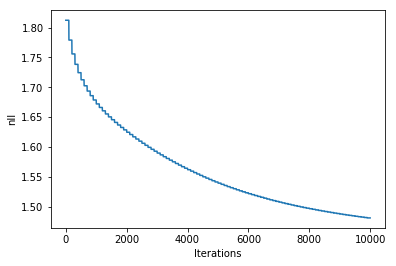

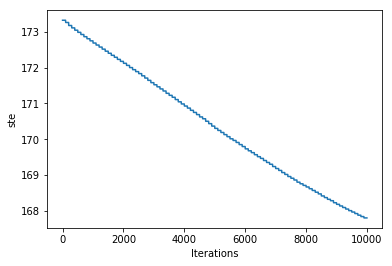

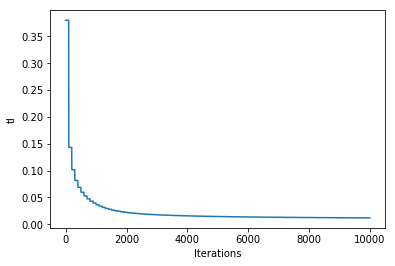

10000 163337500 1.668398 0.022193 1.660024 0.011807
11000 163337500 1.621599 0.009798 1.653424 0.011553
12000 163337500 1.567297 0.009354 1.647820 0.011338
13000 163337500 1.581744 0.016719 1.643125 0.011158
14000 163337500 1.545681 0.008574 1.639051 0.011009
15000 163337500 1.608674 0.012735 1.635357 0.010878
16000 163337500 1.610254 0.016281 1.632079 0.010765
17000 163337500 1.616176 0.005814 1.629270 0.010666
18000 163337500 1.625041 0.021980 1.626723 0.010581
19000 163337500 1.625391 0.016237 1.624409 0.010507


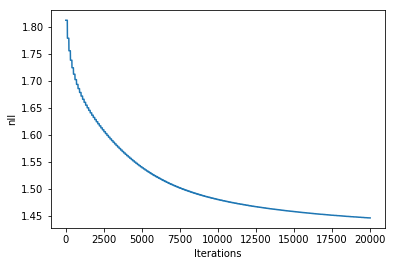

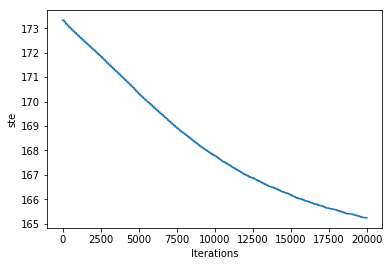

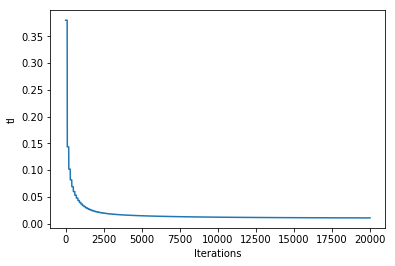

20000 163337500 1.552457 0.008225 1.622233 0.010437
21000 163337500 1.570035 0.009338 1.620317 0.010376
22000 163337500 1.470298 0.006821 1.618605 0.010320
23000 163337500 1.587864 0.007088 1.616941 0.010268
24000 163337500 1.514902 0.009132 1.615376 0.010219
25000 163337500 1.644851 0.006822 1.613904 0.010177
26000 163337500 1.575794 0.011272 1.612459 0.010138
27000 163337500 1.598723 0.007848 1.611110 0.010098
28000 163337500 1.596282 0.013270 1.609968 0.010063
29000 163337500 1.545419 0.012357 1.608769 0.010029


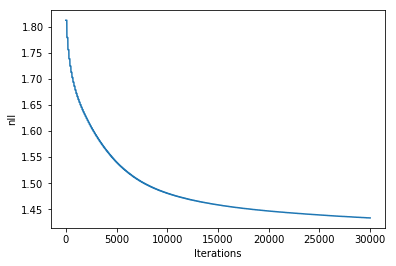

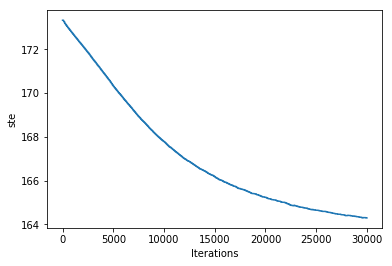

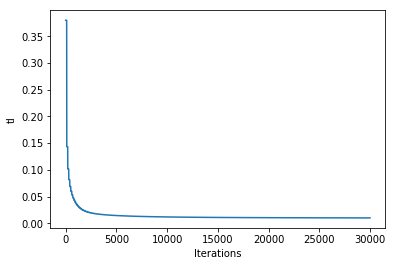

30000 163337500 1.688501 0.008635 1.607592 0.010000
31000 163337500 1.623878 0.011689 1.606574 0.009972
32000 163337500 1.543334 0.007977 1.605593 0.009945
33000 163337500 1.519359 0.004490 1.604631 0.009920
34000 163337500 1.462264 0.009507 1.603797 0.009896
35000 163337500 1.574834 0.018567 1.602861 0.009875
36000 163337500 1.631758 0.011485 1.602046 0.009853
37000 163337500 1.515687 0.004511 1.601242 0.009835
38000 163337500 1.615484 0.009745 1.600435 0.009816
39000 163337500 1.514553 0.009698 1.599671 0.009799


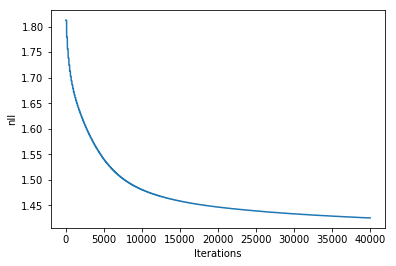

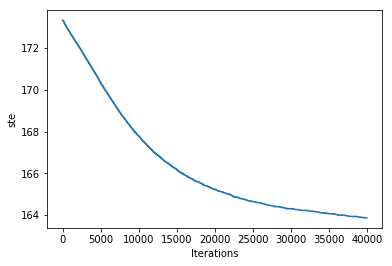

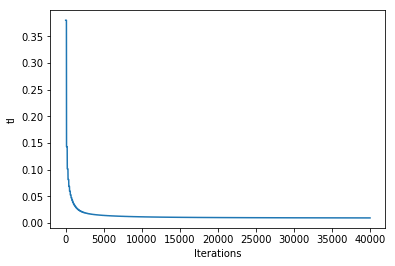

40000 163337500 1.619160 0.009960 1.598984 0.009783
41000 163337500 1.526829 0.007917 1.598257 0.009767
42000 163337500 1.593508 0.014661 1.597550 0.009754
43000 163337500 1.609656 0.009272 1.596868 0.009740
44000 163337500 1.392203 0.011167 1.596162 0.009727
45000 163337500 1.531007 0.009329 1.595570 0.009713
46000 163337500 1.555179 0.008495 1.595022 0.009701
47000 163337500 1.516629 0.008386 1.594439 0.009689
48000 163337500 1.496921 0.007508 1.593790 0.009676
49000 163337500 1.623149 0.008503 1.593217 0.009666


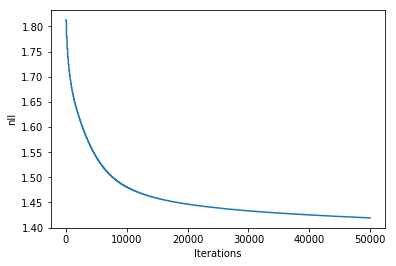

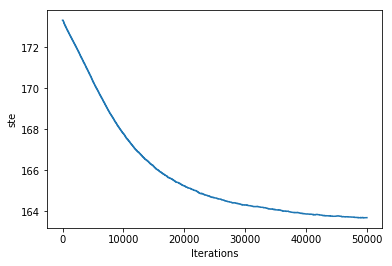

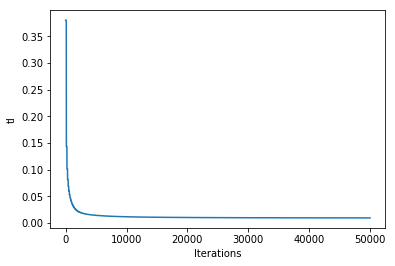

50000 163337500 1.581155 0.008404 1.592602 0.009655
51000 163337500 1.556195 0.016071 1.592100 0.009644
52000 163337500 1.545326 0.010813 1.591480 0.009633
53000 163337500 1.666387 0.012829 1.591046 0.009627
54000 163337500 1.593473 0.011723 1.590570 0.009621
55000 163337500 1.561573 0.006135 1.590092 0.009607
56000 163337500 1.594388 0.017324 1.589613 0.009598
57000 163337500 1.540448 0.007198 1.589048 0.009591
58000 163337500 1.503716 0.007861 1.588652 0.009583
59000 163337500 1.566714 0.006031 1.588194 0.009576


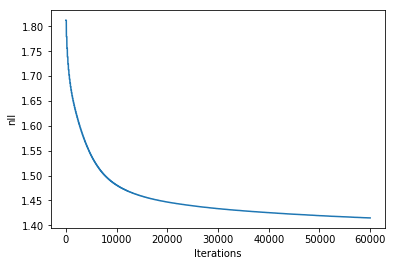

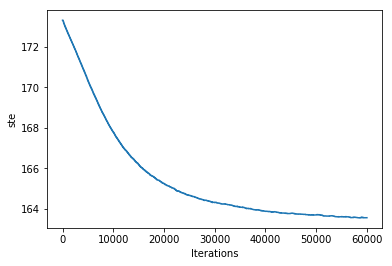

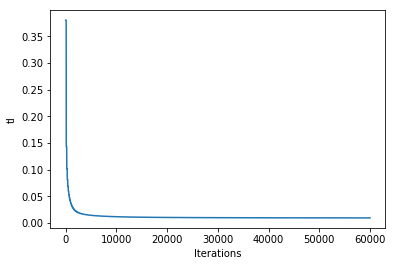

60000 163337500 1.580638 0.006183 1.587847 0.009567
61000 163337500 1.538887 0.010338 1.587343 0.009562
62000 163337500 1.628305 0.011908 1.587046 0.009553
63000 163337500 1.583737 0.007945 1.586570 0.009545
64000 163337500 1.462079 0.009030 1.586124 0.009539
65000 163337500 1.511221 0.009903 1.585803 0.009532
66000 163337500 1.571911 0.013079 1.585379 0.009527
67000 163337500 1.453302 0.010837 1.584970 0.009519
68000 163337500 1.578931 0.008782 1.584629 0.009513
69000 163337500 1.577306 0.007810 1.584285 0.009507


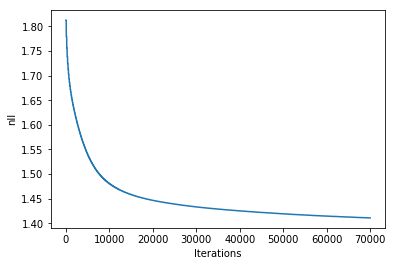

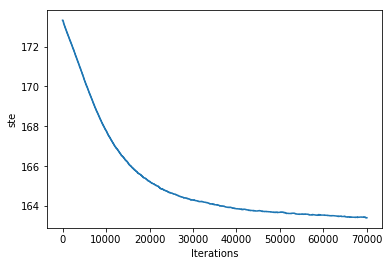

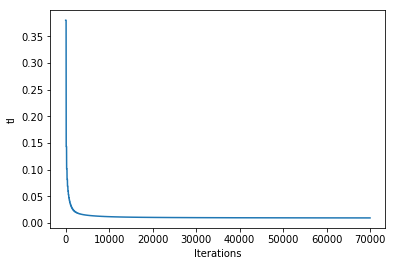

70000 163337500 1.644262 0.009791 1.583899 0.009502
71000 163337500 1.483695 0.008485 1.583524 0.009496
72000 163337500 1.513758 0.009334 1.583200 0.009491
73000 163337500 1.585698 0.006445 1.582839 0.009486
74000 163337500 1.555200 0.010452 1.582532 0.009481
75000 163337500 1.554067 0.006519 1.582223 0.009474
76000 163337500 1.417755 0.010222 1.581880 0.009470
77000 163337500 1.614228 0.006557 1.581605 0.009464
78000 163337500 1.534343 0.014796 1.581322 0.009459
79000 163337500 1.476716 0.008317 1.581002 0.009456


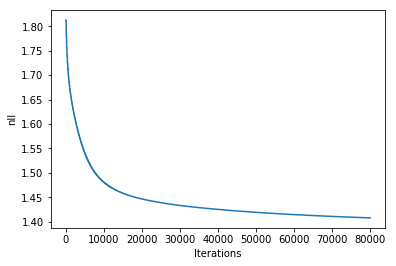

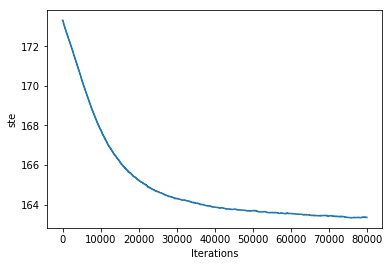

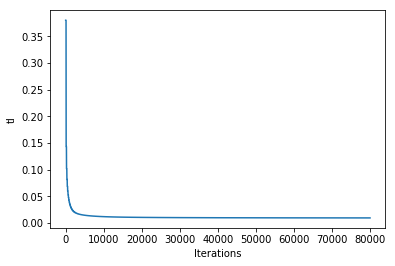

80000 163337500 1.517067 0.007464 1.580722 0.009450
81000 163337500 1.595551 0.007954 1.580374 0.009445
82000 163337500 1.588841 0.008500 1.580116 0.009440
83000 163337500 1.522202 0.004278 1.579860 0.009437
84000 163337500 1.508571 0.007146 1.579599 0.009432
85000 163337500 1.641238 0.009488 1.579355 0.009430
86000 163337500 1.432035 0.005463 1.579072 0.009424
87000 163337500 1.647252 0.009983 1.578788 0.009419
88000 163337500 1.455930 0.007397 1.578588 0.009415
89000 163337500 1.538397 0.008815 1.578349 0.009411


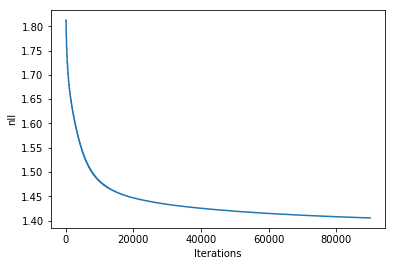

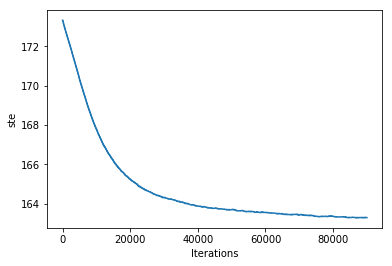

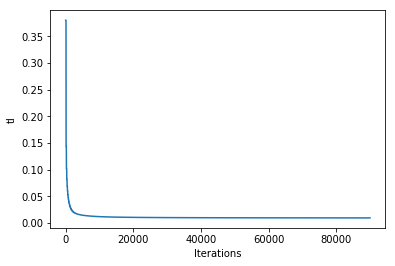

90000 163337500 1.572643 0.008521 1.578103 0.009406
91000 163337500 1.576888 0.004957 1.577838 0.009402
92000 163337500 1.537124 0.009297 1.577634 0.009399
93000 163337500 1.623960 0.007449 1.577390 0.009395
94000 163337500 1.522941 0.013019 1.577152 0.009392
95000 163337500 1.501432 0.007457 1.576961 0.009388
96000 163337500 1.528371 0.006283 1.576677 0.009385
97000 163337500 1.507474 0.009337 1.576461 0.009381
98000 163337500 1.621129 0.005789 1.576253 0.009378
99000 163337500 1.609964 0.009448 1.576026 0.009375


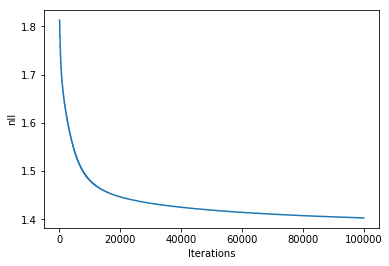

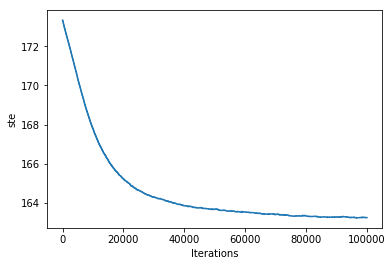

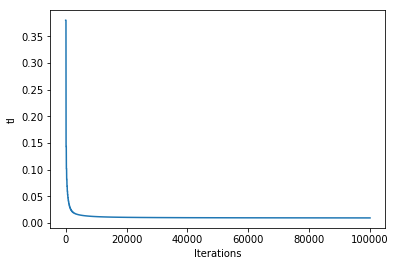

Sampling more constraints
100000 163337500 1.526076 0.007410 1.575836 0.009370
101000 163337500 1.583779 0.008227 1.575672 0.009366
102000 163337500 1.559885 0.011763 1.575402 0.009363
103000 163337500 1.508916 0.004806 1.575220 0.009359
104000 163337500 1.521837 0.011251 1.574989 0.009355
105000 163337500 1.518549 0.012098 1.574842 0.009353
106000 163337500 1.600718 0.010661 1.574631 0.009350
107000 163337500 1.479414 0.009085 1.574493 0.009347
108000 163337500 1.582929 0.006626 1.574313 0.009345
109000 163337500 1.549179 0.010158 1.574101 0.009342


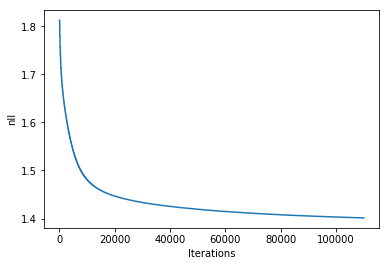

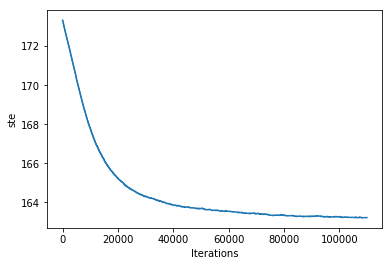

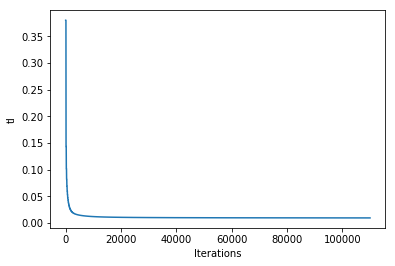

110000 163337500 1.705714 0.006196 1.573920 0.009338
111000 163337500 1.543751 0.011985 1.573833 0.009335
112000 163337500 1.588116 0.007979 1.573548 0.009332
113000 163337500 1.456313 0.006225 1.573426 0.009329
114000 163337500 1.446499 0.006915 1.573241 0.009326
115000 163337500 1.470583 0.006273 1.572973 0.009322
116000 163337500 1.591019 0.007947 1.572857 0.009320
117000 163337500 1.538484 0.007528 1.572771 0.009318
118000 163337500 1.563413 0.004754 1.572556 0.009314
119000 163337500 1.617643 0.007812 1.572455 0.009312


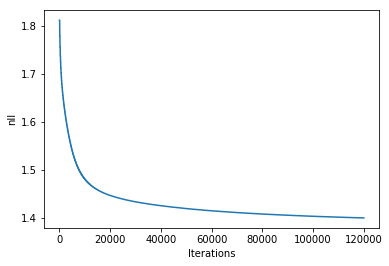

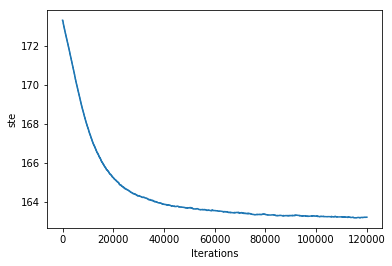

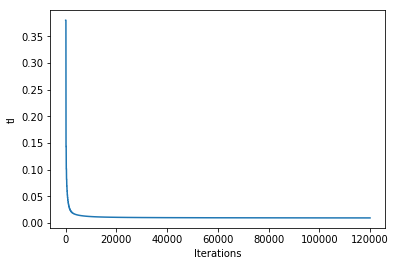

120000 163337500 1.555940 0.006247 1.572292 0.009309
121000 163337500 1.578246 0.005984 1.572106 0.009307
122000 163337500 1.519569 0.005781 1.571935 0.009302
123000 163337500 1.575063 0.009606 1.571787 0.009303
124000 163337500 1.539673 0.011172 1.571667 0.009298
125000 163337500 1.596768 0.007580 1.571479 0.009295
126000 163337500 1.629540 0.010008 1.571347 0.009293
127000 163337500 1.513253 0.008339 1.571165 0.009290
128000 163337500 1.521403 0.010021 1.571034 0.009289
129000 163337500 1.477717 0.010338 1.570937 0.009286


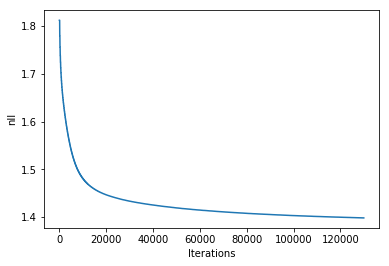

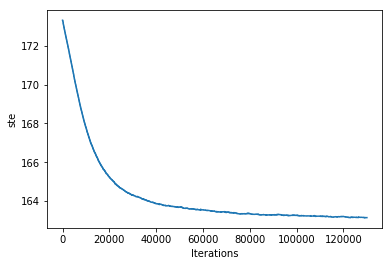

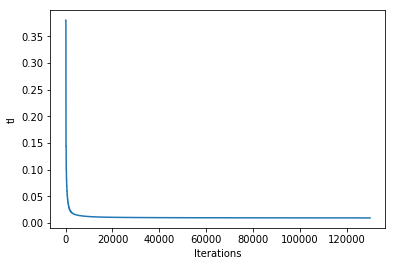

130000 163337500 1.606518 0.010862 1.570739 0.009284
131000 163337500 1.462690 0.007100 1.570660 0.009281
132000 163337500 1.590518 0.004393 1.570507 0.009278
133000 163337500 1.433953 0.013694 1.570358 0.009276
134000 163337500 1.516106 0.008139 1.570265 0.009273
135000 163337500 1.489175 0.007586 1.570053 0.009271
136000 163337500 1.451735 0.008826 1.569964 0.009268
137000 163337500 1.623032 0.013793 1.569737 0.009267
138000 163337500 1.607984 0.004865 1.569648 0.009263
139000 163337500 1.581004 0.006613 1.569553 0.009261


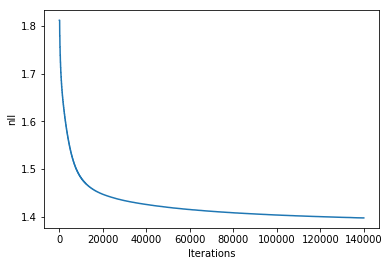

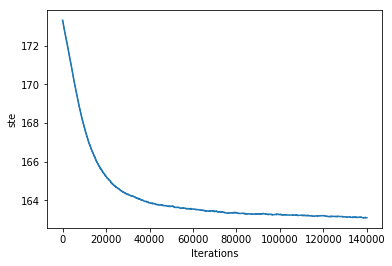

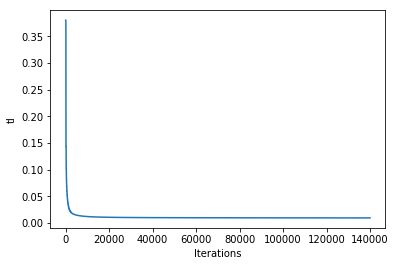

140000 163337500 1.531182 0.007252 1.569477 0.009258
141000 163337500 1.478925 0.010050 1.569366 0.009255
142000 163337500 1.415526 0.006047 1.569157 0.009254
143000 163337500 1.545998 0.006311 1.569061 0.009251
144000 163337500 1.516712 0.008817 1.568956 0.009249
145000 163337500 1.600175 0.010691 1.568893 0.009247
146000 163337500 1.548335 0.007077 1.568729 0.009244
147000 163337500 1.599873 0.012956 1.568614 0.009241
148000 163337500 1.479839 0.009058 1.568497 0.009239
149000 163337500 1.515884 0.004752 1.568338 0.009237


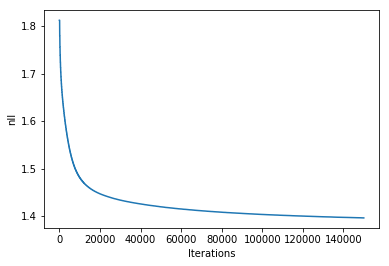

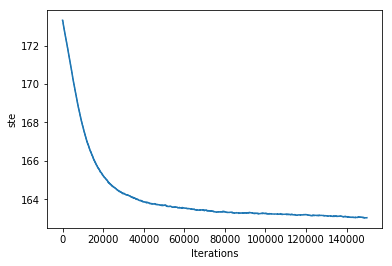

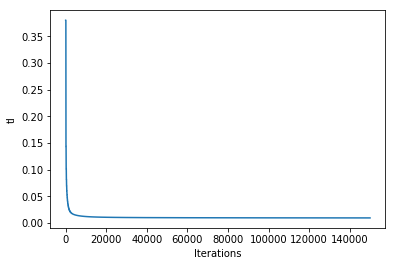

150000 163337500 1.576563 0.007680 1.568196 0.009234
151000 163337500 1.561563 0.010720 1.568051 0.009233
152000 163337500 1.540834 0.007365 1.567885 0.009231
153000 163337500 1.544117 0.017822 1.567828 0.009228
154000 163337500 1.530232 0.006456 1.567760 0.009226
155000 163337500 1.517135 0.010762 1.567624 0.009223
156000 163337500 1.547055 0.006151 1.567534 0.009221
157000 163337500 1.620942 0.004060 1.567449 0.009219
158000 163337500 1.523921 0.011091 1.567333 0.009219
159000 163337500 1.543837 0.006324 1.567231 0.009218


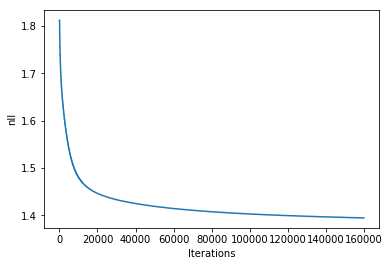

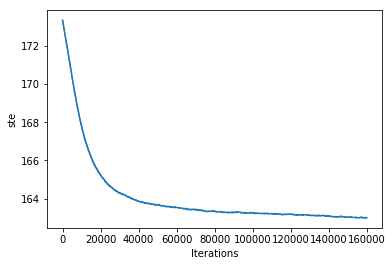

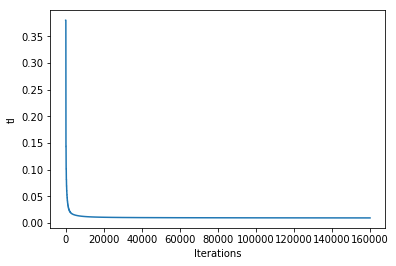

160000 163337500 1.449961 0.012633 1.567110 0.009214
161000 163337500 1.505741 0.008176 1.567075 0.009210
162000 163337500 1.566244 0.009315 1.566968 0.009207
163000 163337500 1.533994 0.009160 1.566846 0.009206
164000 163337500 1.575857 0.007577 1.566637 0.009203
165000 163337500 1.591743 0.005803 1.566546 0.009201
166000 163337500 1.650198 0.007786 1.566480 0.009200
167000 163337500 1.606237 0.011995 1.566333 0.009199
168000 163337500 1.549373 0.006682 1.566264 0.009194
169000 163337500 1.432865 0.010657 1.566206 0.009193


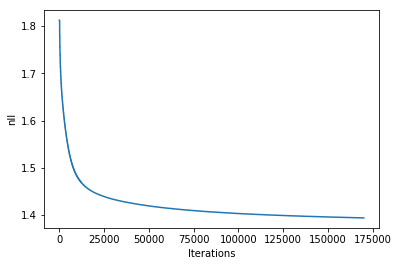

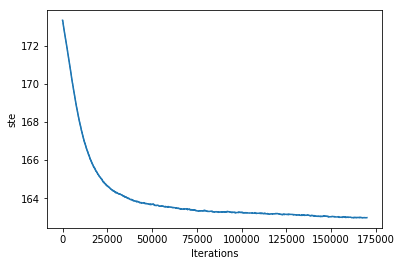

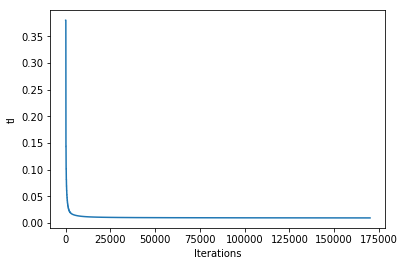

170000 163337500 1.539719 0.008718 1.566101 0.009191
171000 163337500 1.505649 0.010974 1.565989 0.009188
172000 163337500 1.458851 0.005670 1.565916 0.009186
173000 163337500 1.467836 0.005857 1.565822 0.009184
174000 163337500 1.482509 0.006699 1.565721 0.009182
175000 163337500 1.526886 0.008534 1.565653 0.009179
176000 163337500 1.504052 0.008767 1.565493 0.009176
177000 163337500 1.448657 0.007845 1.565411 0.009175
178000 163337500 1.464154 0.012518 1.565353 0.009174
179000 163337500 1.502818 0.007998 1.565256 0.009170


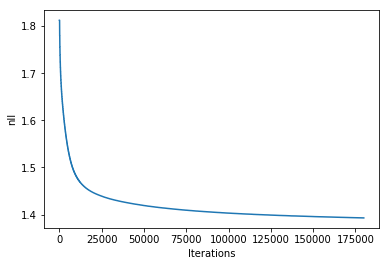

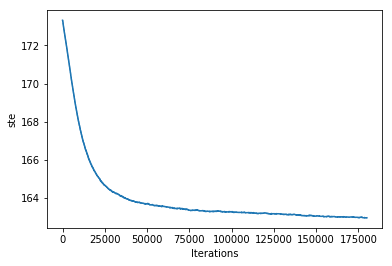

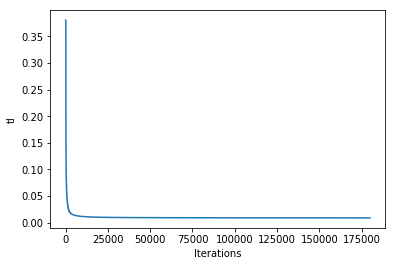

180000 163337500 1.571617 0.007638 1.565122 0.009168
181000 163337500 1.432489 0.006445 1.565044 0.009167
182000 163337500 1.563400 0.009140 1.564955 0.009162
183000 163337500 1.462518 0.009299 1.564870 0.009160
184000 163337500 1.540855 0.018525 1.564808 0.009156
185000 163337500 1.520775 0.009596 1.564713 0.009154
186000 163337500 1.584563 0.015514 1.564621 0.009152
187000 163337500 1.530220 0.005974 1.564548 0.009148
188000 163337500 1.611686 0.008723 1.564421 0.009148
189000 163337500 1.673950 0.009184 1.564394 0.009146


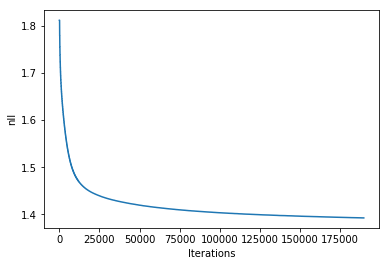

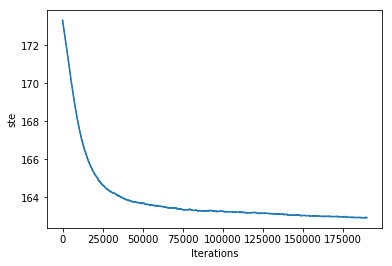

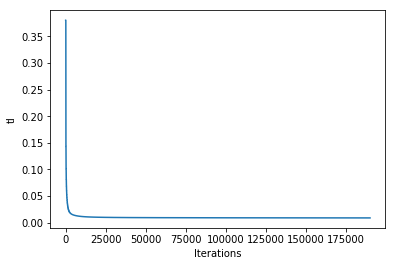

190000 163337500 1.511964 0.004568 1.564267 0.009143
191000 163337500 1.653631 0.010217 1.564184 0.009141
192000 163337500 1.519338 0.011212 1.564152 0.009141
193000 163337500 1.529529 0.005086 1.564032 0.009137
194000 163337500 1.439248 0.006913 1.563916 0.009134
195000 163337500 1.582349 0.005091 1.563879 0.009133
196000 163337500 1.549623 0.007594 1.563769 0.009130
197000 163337500 1.653003 0.007061 1.563719 0.009127
198000 163337500 1.553121 0.011920 1.563592 0.009125
199000 163337500 1.559419 0.008191 1.563539 0.009122


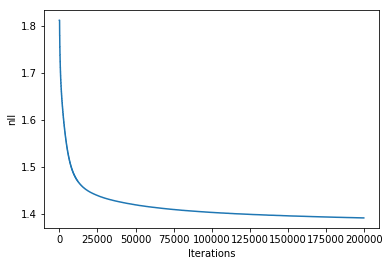

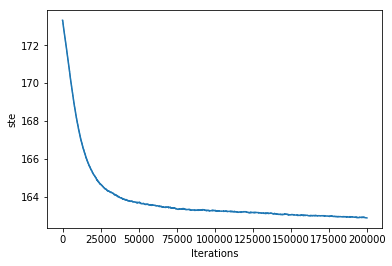

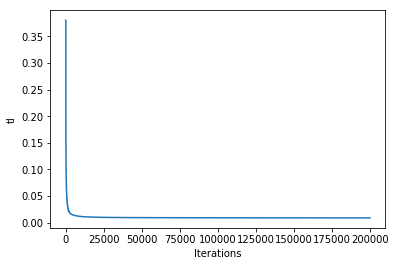

Sampling more constraints


KeyboardInterrupt: 

In [80]:
val_log = None
while len(full_train_logs['loss_evals']) < n_iters:
  demo_batch = sample_batch(batch_size)
  constraint_batch = sample_constraint_batch(constraint_batch_size, len(full_train_logs['loss_evals']) == 0)
  t = len(full_train_logs['loss_evals'])
  train_log = compute_batch_loss(demo_batch, constraint_batch, step=True, t=t)
  if val_log is None or len(full_train_logs['loss_evals']) % val_update_freq == 0:
    val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, step=False, t=t)
  
  if len(full_train_logs['loss_evals']) % 1000 == 0:
      print('%d %d %f %f %f %f' % (
        t, n_iters, train_log['loss'], train_log['tl'], val_log['loss'], val_log['tl'])
      )
  for k, v in train_log.items():
    full_train_logs['%s_evals' % k].append(v)
  for k, v in val_log.items():
    full_train_logs['%s%s_evals' % ('val_' if k in ['loss', 'nll', 'ste', 'tl'] else '', k)].append(v)
  if len(full_train_logs['loss_evals']) % 10000 == 0:
    for k in ['val_nll_evals', 'val_ste_evals', 'val_tl_evals']:
      plt.xlabel('Iterations')
      plt.ylabel(k.split('_')[1])
      plt.plot(full_train_logs[k])
      plt.show()

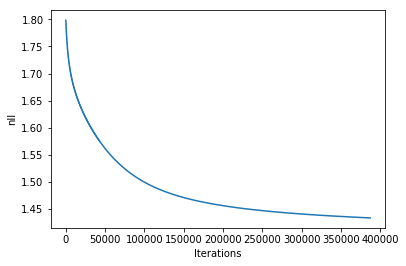

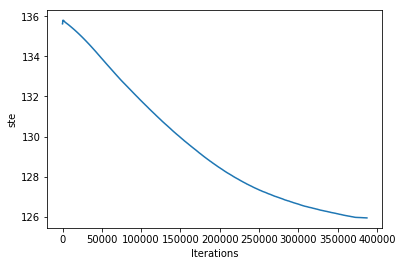

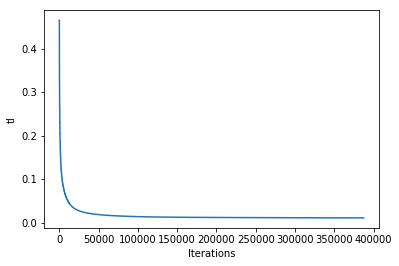

In [164]:
for k in ['val_nll_evals', 'val_ste_evals', 'val_tl_evals']:
  plt.xlabel('Iterations')
  plt.ylabel(k.split('_')[1])
  plt.plot(full_train_logs[k])
  plt.show()

In [81]:
invdyn_r_path = os.path.join(data_dir, 'invdyn_r_stop.tf')

In [82]:
save_tf_vars(sess, invdyn_scope, invdyn_r_path)
# load_tf_vars(sess, invdyn_scope, invdyn_r_path)

In [99]:
# with open(os.path.join(data_dir, 'qt_r_stop_results.pkl'), 'wb') as f:
#   pickle.dump(full_train_logs, f)

In [163]:
with open(os.path.join(data_dir, 'qt_r_results.pkl'), 'rb') as f:
  full_train_logs = pickle.load(f)

## Learning Dynamics Without Reward

In [83]:
train_constraint_example_idxes = None
constraint_obs_t = None
constraint_act_t = None
constraint_act_t_feats = None
n_iters_since_prev_constraint_sample = 0

tf.global_variables_initializer().run(session=sess)

n_iters = iterations * demo_obs.shape[1] // batch_size

trans_train_logs = {
  'loss_evals': [],
  'nll_evals': [],
  'ste_evals': [],
  'val_loss_evals': [],
  'val_nll_evals': [],
  'val_ste_evals': [],
  'int_dyn_err_evals': []
}
val_log = None

Sampling more constraints
Setting val constraint batch
0 163337500 0.386606 0.376672
1000 163337500 0.035441 0.042024
2000 163337500 0.024179 0.024059
3000 163337500 0.017269 0.019736
4000 163337500 0.019272 0.017675
5000 163337500 0.015981 0.016331
6000 163337500 0.011513 0.015354
7000 163337500 0.010886 0.014596
8000 163337500 0.014216 0.013994
9000 163337500 0.009384 0.013492


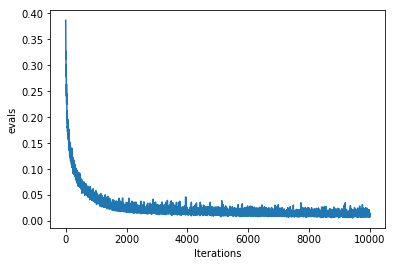

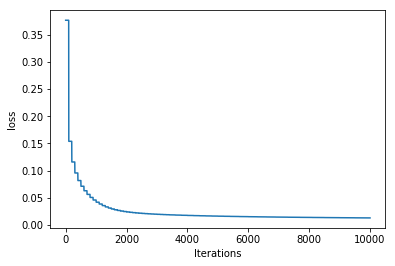

10000 163337500 0.011947 0.013062
11000 163337500 0.008808 0.012685
12000 163337500 0.008457 0.012357
13000 163337500 0.010066 0.012067
14000 163337500 0.007873 0.011809
15000 163337500 0.010781 0.011577
16000 163337500 0.009664 0.011373
17000 163337500 0.009873 0.011188
18000 163337500 0.007996 0.011025
19000 163337500 0.014619 0.010881


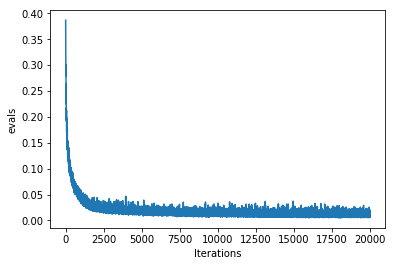

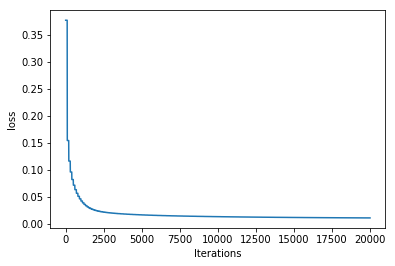

20000 163337500 0.013448 0.010752
21000 163337500 0.009935 0.010641
22000 163337500 0.012388 0.010547
23000 163337500 0.011273 0.010458
24000 163337500 0.009856 0.010385
25000 163337500 0.009178 0.010321
26000 163337500 0.008255 0.010263
27000 163337500 0.004660 0.010210
28000 163337500 0.008634 0.010163
29000 163337500 0.008736 0.010124


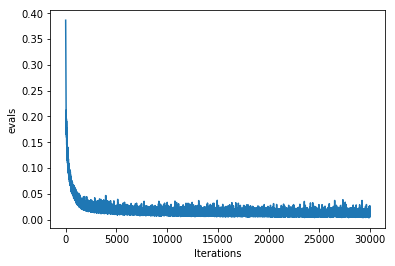

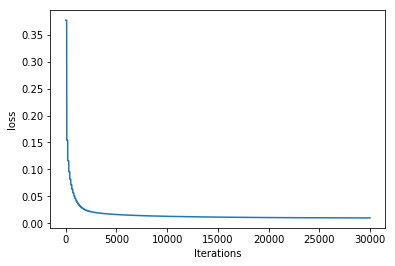

30000 163337500 0.009712 0.010086
31000 163337500 0.011731 0.010052
32000 163337500 0.004708 0.010019
33000 163337500 0.014623 0.009993
34000 163337500 0.010315 0.009965
35000 163337500 0.012797 0.009939
36000 163337500 0.013329 0.009917
37000 163337500 0.010322 0.009895
38000 163337500 0.011718 0.009875
39000 163337500 0.006625 0.009855


KeyboardInterrupt: 

In [84]:
while len(trans_train_logs['loss_evals']) < n_iters:
  demo_batch = sample_batch(batch_size)
  constraint_batch = sample_constraint_batch(constraint_batch_size, len(trans_train_logs['loss_evals']) == 0)  
  t = len(trans_train_logs['loss_evals'])
  train_log = compute_batch_loss(demo_batch, constraint_batch, trans_only=True, step=True, t=t)
  if val_log is None or len(trans_train_logs['loss_evals']) % val_update_freq == 0:
    val_log = compute_batch_loss(val_demo_batch, val_constraint_batch, trans_only=True, step=False, t=t)
  
  if len(trans_train_logs['loss_evals']) % 1000 == 0:
      print('%d %d %f %f' % (
        t, n_iters, train_log['loss'], val_log['loss'],)
      )

  trans_train_logs['loss_evals'].append(train_log['loss'])
  trans_train_logs['val_loss_evals'].append(val_log['loss'])
  if len(trans_train_logs['loss_evals']) % 10000 == 0:
    for k in ['loss_evals', 'val_loss_evals']:
      plt.xlabel('Iterations')
      plt.ylabel(k.split('_')[1])
      plt.plot(trans_train_logs[k])
      plt.show()

In [95]:
invdyn_nr_path = os.path.join(data_dir, 'invdyn_nr.tf')

In [106]:
# save_tf_vars(sess, invdyn_scope, invdyn_nr_path)
load_tf_vars(sess, invdyn_scope, invdyn_nr_path)

INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf


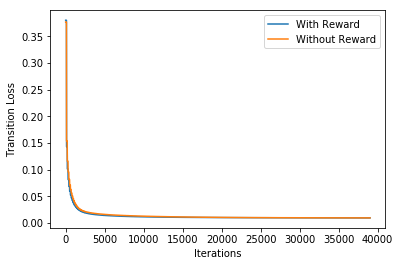

In [85]:
plt.xlabel('Iterations')
plt.ylabel("Transition Loss")
plt.plot(full_train_logs['val_tl_evals'][:len(trans_train_logs['val_loss_evals'])], label="With Reward")
plt.plot(trans_train_logs['val_loss_evals'], label="Without Reward")
plt.legend()

# Test Learned Dynamics Under Covariate Shift

In [78]:
# load_tf_vars(sess, invdyn_scope, invdyn_nr_path)

invdyn_nr_path = os.path.join(data_dir, 'invdyn_nr.tf')
load_tf_vars(sess, invdyn_scope, invdyn_nr_path)

invdyn_r_path = os.path.join(data_dir, 'invdyn_r.tf')
load_tf_vars(sess, invdyn_scope, invdyn_r_path)

INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf


In [79]:
train_task_idx = 1
policy = lambda _ : disc_to_cont(np.random.choice(n_act_dim, 1)[0])
# policy = pilot_policies[train_task_idx]
test_rollouts = [run_ep(policy, train_envs[train_task_idx], task_idx=train_task_idx) for _ in range(10)]

In [80]:
obs_ph = tf.placeholder(tf.float32, [None, n_obs_feats])
act_feats_ph = tf.placeholder(tf.float32, [None, n_act_feats])


test_pred_obs = build_mlp(
  tf.concat((obs_ph, act_feats_ph), axis=1),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [81]:
def test_learned_transitions(rollouts, obs_ph, act_ph, pred_obs): 
    prev_obs, act_feats, obs = [],[],[]
    for rollout in rollouts:
      more_obs, more_actions, _, more_next_obs = list(zip(*rollout))[:4]
      prev_obs.extend([featurize_obs(s) for s in more_obs])
      more_act_feats = [disc_to_cont(a) for a in more_actions]
      act_feats.extend(more_act_feats)
      obs.extend([featurize_obs(s) for s in more_next_obs])
    eval_pred_obs = sess.run([pred_obs], feed_dict={obs_ph:prev_obs,
                                                    act_ph: act_feats})[0]
    return (np.array(obs), np.array(eval_pred_obs))

In [82]:
base, with_reward, without_reward = [], [], []
for _ in range(100):
    test_rollouts = [run_ep(policy, train_envs[train_task_idx], task_idx=train_task_idx) for _ in range(10)]
    load_tf_vars(sess, invdyn_scope, invdyn_r_path)
    res = test_learned_transitions(test_rollouts, obs_ph, act_feats_ph, test_pred_obs)
    base += [res[0]]
    with_reward += [res[1]]
    load_tf_vars(sess, invdyn_scope, invdyn_nr_path)
    res = test_learned_transitions(test_rollouts, obs_ph, act_feats_ph, test_pred_obs)
    without_reward += [res[1]]

INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4

INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_nr.tf
INFO:tensorflow:Restoring parameters from data/4.0/invdyn_r.tf
INFO:tensorflow:Restoring parameters from data/4

In [83]:
base = np.array(base)
with_rewardward = np.array(with_reward)
without_reward = np.array(without_reward)

In [84]:
print(abs(base - with_reward)[-1].mean(), abs(base - with_reward)[-1].std())
print(abs(base - without_reward)[-1].mean(), abs(base - without_reward)[-1].std())


0.1259969775874609 0.2176593392616892
0.11323035490298183 0.14598479815165294


In [85]:
print(res[0].max(axis=0), res[1].max(axis=0))
print(res[0].min(axis=0), res[1].min(axis=0))

[ 1.00927544  1.16641703  2.58369637  0.7240026   0.84427619  2.21501231
  1.          1.         -0.6       ] [0.47867543 1.2282597  2.2768722  0.537261   0.9794843  1.2429745
 0.68699914 0.84034526 0.5189687 ]
[-1.01633286 -0.08478078 -1.93998003 -1.7430714  -1.04067743 -1.74532199
  0.          0.         -0.6       ] [-0.6477588  -0.11690153 -1.9303981  -1.7621561  -0.8988353  -1.1990738
 -0.22449626 -0.12373005 -0.8350276 ]


In [200]:
abs(res[0] - res[1]).max(axis=0)

array([0.39806961, 1.32967598, 1.37797195, 1.10204041, 1.43341744,
       6.16821095, 0.93413513, 0.98487296, 0.84771577])

# Use Q-vals for policy

In [151]:
train_task_idx = 6
train_env = train_envs[train_task_idx]
obs_t_ph = tf.placeholder(tf.float32, [None, n_obs_feats], name="ot")

training_qs = build_mlp(
    obs_t_ph,
    n_act_dim, q_scope+'-'+str(train_task_idx), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

policy_action = tf.argmax(training_qs, axis=1)

In [152]:
 def run_q_pol_ep(policy_action, obs_ph, env, max_ep_len=max_ep_len, render=False, task_idx=None):
  obs = env.reset()
  done = False
  totalr = 0.
  prev_obs = obs
  rollout = []
  for step_idx in range(max_ep_len+1):
    if done:
      break
    action = sess.run(policy_action, feed_dict={obs_ph:np.array([obs])})[0]
    obs, r, done, info = env.step(action)
    rollout.append((prev_obs, action, r, obs, float(done), task_idx))
    prev_obs = obs
    if render:
      env.render()
    totalr += r
  return rollout

In [153]:
%autoreload
run_q_pol_ep(policy_action, obs_t_ph, train_env, render=True, task_idx=train_task_idx)

[(array([-0.01157541,  0.92923461, -1.17248046, -0.75864625,  0.01341981,
          0.2655845 ,  0.        ,  0.        ,  0.4       ]),
  5,
  1.3654568542878247,
  array([-0.02311401,  0.91831475, -1.16519821, -0.72812772,  0.02463802,
          0.22439241,  0.        ,  0.        ,  0.4       ]),
  0.0,
  6),
 (array([-0.02311401,  0.91831475, -1.16519821, -0.72812772,  0.02463802,
          0.22439241,  0.        ,  0.        ,  0.4       ]),
  5,
  1.713166629685045,
  array([-0.03441429,  0.90749016, -1.13990748, -0.72183259,  0.03440942,
          0.19545083,  0.        ,  0.        ,  0.4       ]),
  0.0,
  6),
 (array([-0.03441429,  0.90749016, -1.13990748, -0.72183259,  0.03440942,
          0.19545083,  0.        ,  0.        ,  0.4       ]),
  5,
  0.07567182651441953,
  array([-0.04568796,  0.89674607, -1.13529932, -0.71647803,  0.04227278,
          0.15728521,  0.        ,  0.        ,  0.4       ]),
  0.0,
  6),
 (array([-0.04568796,  0.89674607, -1.13529932, -0.7164780

In [154]:
train_envs[train_task_idx].close()

In [158]:
test_rollouts = [run_q_pol_ep(policy_action, obs_t_ph, train_env, task_idx=train_task_idx) for _ in range(10)]

In [160]:
res = test_learned_transitions(test_rollouts, obs_ph, act_feats_ph, test_pred_obs)

In [161]:
print(res[0].max(axis=0), res[1].max(axis=0))
print(res[0].min(axis=0), res[1].min(axis=0))

[1.01774406 1.50594149 3.48196435 0.95954069 1.86759746 6.86166191
 1.         1.         0.4       ] [0.11641075 1.0378094  2.645222   0.37160826 1.1121043  5.8747
 0.41995323 0.425705   1.8305973 ]
[-1.0261374  -0.05297393 -3.02902532 -2.47430452 -8.73370934 -9.24979591
  0.          0.          0.4       ] [-0.599837   -0.35963184 -3.0413315  -2.2647743  -4.804176   -2.7457216
 -1.1773534  -0.22642443 -1.4712796 ]


In [112]:
(res[0] - res[1]).max(axis=0)

array([0.05493245, 0.04469968, 0.05337948, 0.07390209, 0.05598798,
       0.39226215, 0.91080505, 0.98371851, 0.14605468])

# Train Q-vals for arbitrary goals using Bellman Residual

In [82]:
obs_t_ph = tf.placeholder(tf.float32, [None, n_obs_feats])
act_t_ph = tf.placeholder(tf.int32, [None])
act_t_feats_ph = tf.placeholder(tf.float32, [None, n_act_feats])
next_obs_t_ph = tf.placeholder(tf.float32, [None, n_obs_feats])
batch_size_ph = tf.placeholder(tf.int32)


con_obs_t_ph = tf.placeholder(tf.float32, [None, n_obs_feats])
con_act_t_ph = tf.placeholder(tf.int32, [None])
con_act_t_feats_ph = tf.placeholder(tf.float32, [None, n_act_feats])
con_rew_t_ph = tf.placeholder(tf.float32, [None])
con_batch_size_ph = tf.placeholder(tf.int32)

In [155]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

def sample_q_learn_constraints(goal, n_samples=n_constraint_rollouts_per_env, q_fn = None):
  constraint_rollouts = []
  rollouts = [[] for _ in range(n_samples)]
  envs = [make_lander_env(goal=goal) for _ in range(n_samples)]
  obses = np.array([env.reset() for env in envs])
  dones = [False for _ in envs]
  prev_obses = obses
  for step_idx in range(max_ep_len+1):
    not_done_idxes = [i for i, done in enumerate(dones) if not done]
    batch_size = len(not_done_idxes)
    if batch_size == 0:
      break
    if q_fn is None:
        actions = np.random.choice(n_act_dim, batch_size)
    else:
        action_probs = sess.run([q_fn], feed_dict={obs_t_ph: np.array(prev_obses)})[0]
        actions = np.array([np.random.choice(n_act_dim, p=softmax(aps)) for aps in action_probs])
    for i, env_idx in enumerate(not_done_idxes):
      env = envs[env_idx]
      action = actions[i]
      obs, r, done, info = env.step(action)
      obses[env_idx] = obs
      dones[env_idx] = done
      rollouts[env_idx].append((prev_obses[env_idx], action, r))
      prev_obses = copy(obses)
    constraint_rollouts.extend([r for r in rollouts if r != []])

  size = sum(len(r) for r in rollouts)
    
  unfeat_obses, actions, rews = list(zip(*sum(constraint_rollouts, [])))
  obses = [featurize_obs(s) for s in unfeat_obses]
  act_feats = [disc_to_cont(a) for a in actions]
  idxes = random.sample(list(range(len(obses))), size)
  constraint_obs_t = np.array(obses)[idxes, :]
  constraint_act_t = np.array(actions)[idxes]
  constraint_rew_t = np.array(rews)[idxes]
  constraint_act_t_feats = np.array(act_feats)[idxes, :]

  
  constraint_example_idxes = list(range(size))
  random.shuffle(constraint_example_idxes)
  n_train_constraint_examples = int(0.9 * size)
  
  train_constraint_example_idxes = constraint_example_idxes[:n_train_constraint_examples]
  train_constraint_batch = [constraint_obs_t[train_constraint_example_idxes],
                            constraint_act_t[train_constraint_example_idxes],
                            constraint_act_t_feats[train_constraint_example_idxes],
                            constraint_rew_t[train_constraint_example_idxes]]
    
  val_constraint_example_idxes = constraint_example_idxes[n_train_constraint_examples:]
  val_constraint_batch = (constraint_obs_t[val_constraint_example_idxes],
                          constraint_act_t[val_constraint_example_idxes],
                          constraint_act_t_feats[val_constraint_example_idxes],
                          constraint_rew_t[val_constraint_example_idxes])

  return train_constraint_batch, val_constraint_batch

In [150]:
def sample_q_learn_constraint_batch(size):
  global train_constraints
  train_constraint_example_idxes = list(range(len(train_constraints[0])))
  idxes = random.sample(train_constraint_example_idxes, size)
  constraint_batch = tuple(map(lambda x: x[idxes], train_constraints))
  return constraint_batch

In [85]:
train_id = 9
qlearn_env = make_lander_env(goal=train_id)

In [87]:
train_constraints[3].shape

(7317,)

In [88]:
con_obs_tp1 = build_mlp(
  tf.concat((con_obs_t_ph, con_act_t_feats_ph), axis=1),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [89]:
# Sampled constraint state q-vals
train_q_t = build_mlp(
    con_obs_t_ph,
    n_act_dim, q_scope+'-'+str(train_id), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation)

In [113]:
pol_q_t = build_mlp(
    obs_t_ph,
    n_act_dim, q_scope+'-'+str(train_id), 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

In [90]:
train_q_tp1 = build_mlp(
    con_obs_tp1, 
    n_act_dim, q_scope+'-'+str(train_id),
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

train_v_tp1 = tf.reduce_logsumexp(train_q_tp1, axis=1)

In [91]:
train_target_t = con_rew_t_ph + gamma * train_v_tp1

In [92]:
# Bellman errors
train_td_err = tf.transpose(tf.transpose(train_q_t) - train_target_t)
train_sq_td_err = tf.reduce_mean(train_td_err**2)

In [93]:
q_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, q_scope+'-'+str(train_id))

In [94]:
train_update_op = tf.train.AdamOptimizer(learning_rate).minimize(train_sq_td_err, var_list=q_train_vars)

In [107]:
def compute_qbatch_loss(constraint_batch, update_op, step=True):
  constraint_batch_obs_t, constraint_batch_act_t, constraint_batch_act_t_feats, constraint_batch_rew_t = constraint_batch

  feed_dict = {
    con_obs_t_ph: constraint_batch_obs_t,
    con_act_t_ph: constraint_batch_act_t,
    con_act_t_feats_ph: constraint_batch_act_t_feats,
    con_rew_t_ph: constraint_batch_rew_t,
    con_batch_size_ph: constraint_batch_obs_t.shape[1],
  }

  sq_td_err_eval = sess.run([train_sq_td_err], feed_dict=feed_dict)[0]
  
  if step:
      sess.run(update_op, feed_dict=feed_dict)
    
  return sq_td_err_eval

In [185]:
train_constraints, val_constraints = sample_q_learn_constraints(train_id)

In [ ]:
tf.global_variables_initializer().run(session=sess)
load_tf_vars(sess, invdyn_scope, invdyn_r_path)

In [ ]:
soft_train_logs = {
  'err': [],
  'val_err':[]
}
max_iters = 1e7

In [ ]:
val_err = None
while len(soft_train_logs['err']) < max_iters:
  constraint_batch = sample_q_learn_constraint_batch(constraint_batch_size)
  t = len(soft_train_logs['err'])
  err = compute_qbatch_loss(constraint_batch, train_update_op)
  if val_err is None or len(soft_train_logs['val_err']) % val_update_freq == 0:
    val_err = compute_qbatch_loss(val_constraints, train_update_op, step=False)
  if len(soft_train_logs['err']) % 1000 == 0:
      print('%d %d %f %f' % (t, n_iters, err, val_err))
  soft_train_logs['err'].append(err)
  soft_train_logs['val_err'].append(val_err)
  if len(soft_train_logs['err']) % 10000 == 0:
    plt.xlabel('Iterations')
    plt.ylabel("Validation Residual Error")
    plt.plot(soft_train_logs['val_err'])
    plt.show()

In [186]:
soft_train_logs = {
  'err': [],
  'val_errs':[[]]
}
max_iters = 1e6

val_errs = []
dagger_iter_rate = 2e4
dagger_constraint_sims = 10
val_constraint_list = [val_constraints]

649000 163337500 8.588401 22.472834


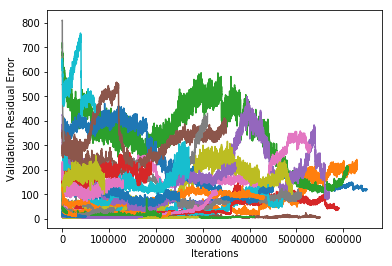

650000 163337500 6.723951 27.717318
651000 163337500 5.331225 22.484041
652000 163337500 33.577244 21.975142
653000 163337500 13.116879 21.420538
654000 163337500 22.561644 17.930984
655000 163337500 4.862115 20.367964
656000 163337500 13.160462 17.794662
657000 163337500 9.062760 17.346138
658000 163337500 3.234781 18.806181
659000 163337500 6.883125 19.177561


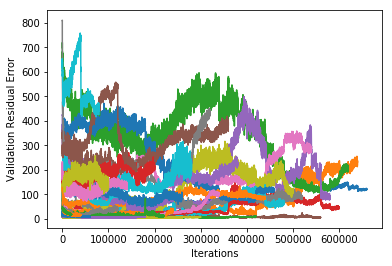

Generating new rollouts
(7376, 9) (689, 9)
(7376,) (689,)
(7376, 2) (689, 2)
(7376,) (689,)
660000 163337500 115.443970 61.760990
661000 163337500 11.866931 43.114243
662000 163337500 6.665266 47.757294
663000 163337500 46.652802 41.597561
664000 163337500 3.898452 56.756184
665000 163337500 13.664861 62.953205
666000 163337500 12.588608 45.415348
667000 163337500 5.301774 50.269608
668000 163337500 16.432745 43.652939
669000 163337500 38.354263 47.788319


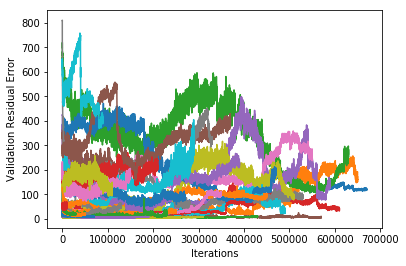

670000 163337500 45.435322 47.993233
671000 163337500 13.483640 48.532093
672000 163337500 4.251121 58.443687
673000 163337500 6.743586 56.948246
674000 163337500 5.085204 59.370701
675000 163337500 6.128499 50.140335
676000 163337500 6.181278 50.789753
677000 163337500 29.162836 45.182663
678000 163337500 94.052856 53.226032
679000 163337500 17.461376 60.445133


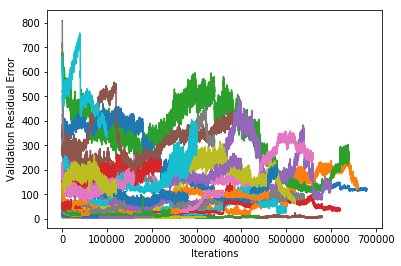

Generating new rollouts
(7376, 9) (671, 9)
(7376,) (671,)
(7376, 2) (671, 2)
(7376,) (671,)
680000 163337500 46.474041 38.578625
681000 163337500 118.470093 40.354080
682000 163337500 14.454224 42.462234
683000 163337500 13.766641 44.824966
684000 163337500 45.705151 44.490665
685000 163337500 20.879578 38.700645
686000 163337500 55.247375 41.016571
687000 163337500 21.646154 38.198215
688000 163337500 121.005318 38.133636
689000 163337500 5.128583 37.294361


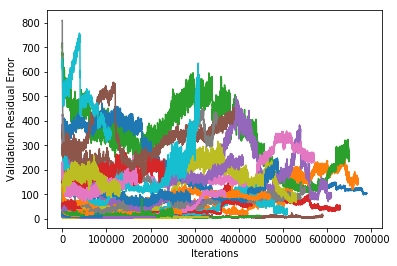

690000 163337500 28.699034 34.986912
691000 163337500 59.166325 39.443211
692000 163337500 32.301640 39.786877
693000 163337500 25.074755 38.917534
694000 163337500 107.860268 36.995182
695000 163337500 44.418705 41.410793
696000 163337500 10.477332 40.051796
697000 163337500 12.232307 42.253410
698000 163337500 68.968613 43.164639
699000 163337500 94.263069 39.154133


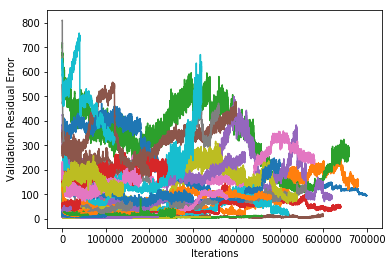

Generating new rollouts
(7376, 9) (679, 9)
(7376,) (679,)
(7376, 2) (679, 2)
(7376,) (679,)
700000 163337500 4.219932 254.764786
701000 163337500 120.239693 285.861267
702000 163337500 9.592137 278.525482
703000 163337500 59.410778 288.781494
704000 163337500 50.323009 269.525360
705000 163337500 6.846402 275.118500
706000 163337500 10.226279 276.971313
707000 163337500 35.362942 278.696472
708000 163337500 23.374548 302.568939
709000 163337500 71.005363 274.600647


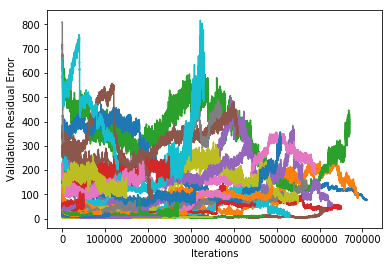

710000 163337500 14.307973 271.293793
711000 163337500 56.385288 281.342316
712000 163337500 68.410835 289.140900
713000 163337500 65.391304 290.608826
714000 163337500 4.321501 292.601837
715000 163337500 31.337317 305.674011
716000 163337500 8.957332 286.981842
717000 163337500 88.892639 294.301605
718000 163337500 7.389433 273.202545
719000 163337500 64.515793 269.049042


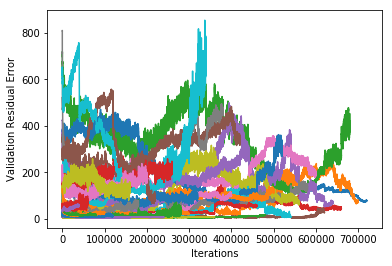

Generating new rollouts
(7376, 9) (577, 9)
(7376,) (577,)
(7376, 2) (577, 2)
(7376,) (577,)
720000 163337500 100.547874 42.819763
721000 163337500 45.434952 40.400532
722000 163337500 8.088111 40.534985
723000 163337500 5.004499 35.370838
724000 163337500 8.833634 37.147991
725000 163337500 66.518547 29.790920
726000 163337500 181.368652 34.435474
727000 163337500 23.946127 27.037884
728000 163337500 5.156483 29.377356
729000 163337500 105.400734 36.808292


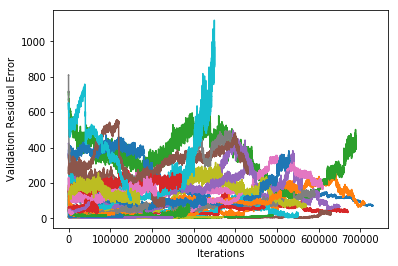

730000 163337500 120.071007 29.965420
731000 163337500 7.892235 28.735817
732000 163337500 4.682789 30.753424
733000 163337500 6.335320 26.391163
734000 163337500 13.811146 27.472298
735000 163337500 27.058374 27.558105
736000 163337500 13.273217 26.621758
737000 163337500 12.745918 28.318752
738000 163337500 13.598042 24.871685
739000 163337500 127.529152 21.418243


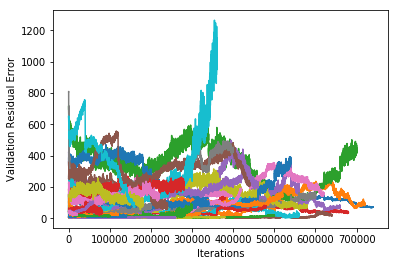

Generating new rollouts
(7376, 9) (644, 9)
(7376,) (644,)
(7376, 2) (644, 2)
(7376,) (644,)
740000 163337500 33.284908 64.288872
741000 163337500 62.561035 39.095280
742000 163337500 19.640091 32.150120
743000 163337500 241.168457 36.977398
744000 163337500 35.671345 31.392689
745000 163337500 14.685464 26.865566
746000 163337500 15.644112 24.738213
747000 163337500 6.163931 24.622765
748000 163337500 89.253326 25.601284
749000 163337500 45.625820 25.588297


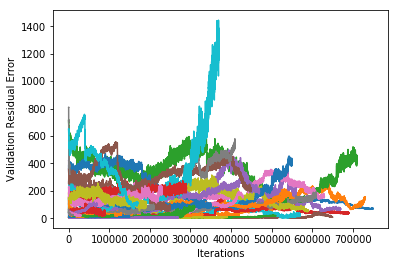

750000 163337500 27.997147 25.151754
751000 163337500 44.393940 23.109949
752000 163337500 5.526200 24.095297
753000 163337500 32.605251 24.963383
754000 163337500 17.075394 23.069145
755000 163337500 12.149297 22.834179
756000 163337500 14.956321 21.144249
757000 163337500 17.318586 23.496683
758000 163337500 95.812630 24.644894
759000 163337500 8.352973 22.367626


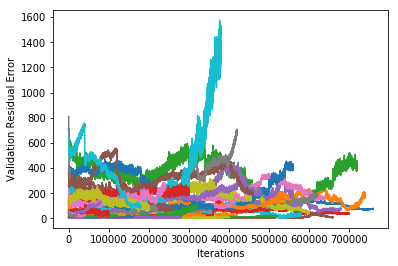

Generating new rollouts
(7376, 9) (600, 9)
(7376,) (600,)
(7376, 2) (600, 2)
(7376,) (600,)
760000 163337500 7.873612 85.448090
761000 163337500 80.785225 88.522476
762000 163337500 5.164140 70.287415
763000 163337500 26.467070 73.135399
764000 163337500 37.814198 75.978470
765000 163337500 63.439381 78.551781
766000 163337500 39.645630 77.247299
767000 163337500 55.236698 76.161163
768000 163337500 14.639157 67.270912
769000 163337500 34.309467 73.899803


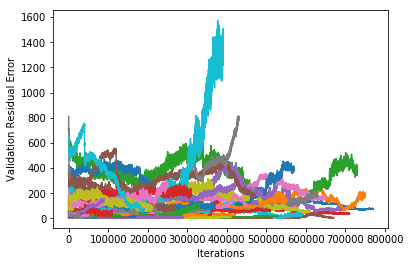

770000 163337500 12.116544 72.781723
771000 163337500 54.610455 74.942352
772000 163337500 19.076059 73.919518
773000 163337500 10.412753 78.827080
774000 163337500 16.732643 80.934502
775000 163337500 5.432112 78.544106
776000 163337500 24.976248 86.045914
777000 163337500 105.792259 89.376732
778000 163337500 166.720718 66.538658
779000 163337500 12.327870 71.366646


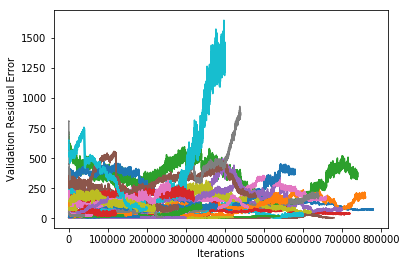

Generating new rollouts
(7376, 9) (693, 9)
(7376,) (693,)
(7376, 2) (693, 2)
(7376,) (693,)
780000 163337500 126.156006 99.021774
781000 163337500 129.596176 47.194828
782000 163337500 58.342907 38.817554
783000 163337500 40.905392 36.794392
784000 163337500 131.848648 35.243504
785000 163337500 16.962723 40.081364
786000 163337500 275.923248 30.908270
787000 163337500 91.712669 33.209339
788000 163337500 14.091205 29.957933
789000 163337500 19.615881 21.788313


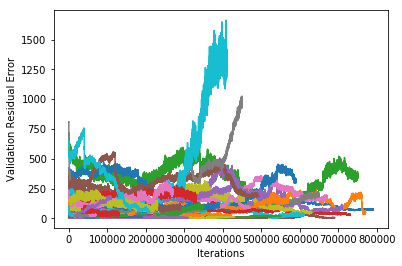

790000 163337500 12.245190 25.516550
791000 163337500 144.378983 23.071800
792000 163337500 6.958139 28.715212
793000 163337500 13.722762 23.243029
794000 163337500 33.526539 30.240973
795000 163337500 53.380890 25.053829
796000 163337500 4.639307 26.930668
797000 163337500 22.522642 22.684431
798000 163337500 36.992344 19.054180
799000 163337500 33.786362 26.106810


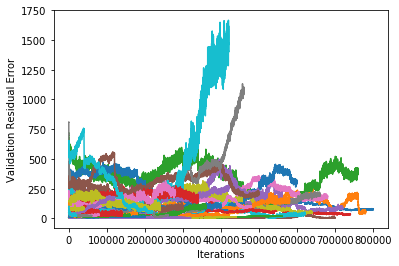

Generating new rollouts
(7376, 9) (720, 9)
(7376,) (720,)
(7376, 2) (720, 2)
(7376,) (720,)
800000 163337500 217.339645 353.511841
801000 163337500 53.264721 74.741821
802000 163337500 53.431000 67.099846
803000 163337500 9.135042 52.151310
804000 163337500 5.321807 63.176765
805000 163337500 43.623539 57.058472
806000 163337500 99.674965 53.352055
807000 163337500 122.103600 57.438343
808000 163337500 56.166809 32.376408
809000 163337500 6.402127 33.256065


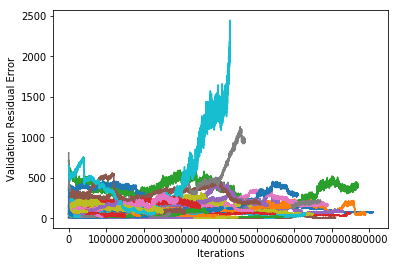

810000 163337500 72.530708 35.336861
811000 163337500 35.956913 35.488228
812000 163337500 122.044373 28.971966
813000 163337500 33.186260 30.962643
814000 163337500 70.693268 30.520628
815000 163337500 38.864857 33.716148
816000 163337500 86.711189 26.123398
817000 163337500 62.588291 24.763870
818000 163337500 186.593994 25.362389
819000 163337500 96.540749 24.836731


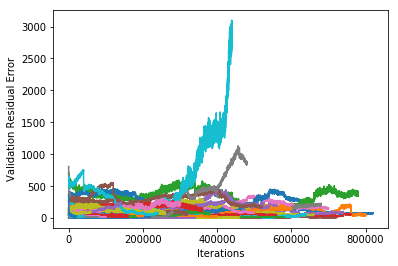

Generating new rollouts
(7376, 9) (628, 9)
(7376,) (628,)
(7376, 2) (628, 2)
(7376,) (628,)
820000 163337500 59.028080 20.769938
821000 163337500 139.375626 52.482693
822000 163337500 200.265457 26.241255
823000 163337500 11.616763 27.227051
824000 163337500 114.203522 29.735542
825000 163337500 10.939883 29.448191
826000 163337500 55.981060 21.551262
827000 163337500 6.820960 22.820692
828000 163337500 20.557047 31.318562
829000 163337500 11.272153 32.420391


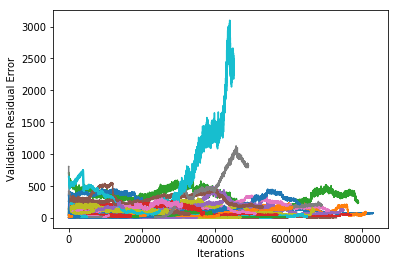

830000 163337500 11.097569 28.295790
831000 163337500 9.538969 25.751116
832000 163337500 37.565582 20.398302
833000 163337500 21.052887 24.539749
834000 163337500 7.592831 28.638319
835000 163337500 21.003382 28.076143
836000 163337500 172.193481 28.514137
837000 163337500 13.350583 25.721447
838000 163337500 82.676094 30.646547
839000 163337500 51.981426 22.285559


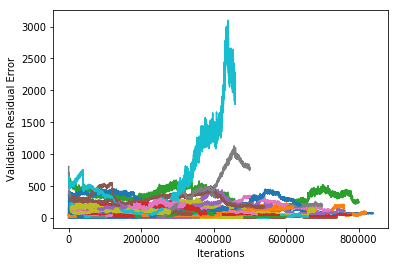

Generating new rollouts
(7376, 9) (772, 9)
(7376,) (772,)
(7376, 2) (772, 2)
(7376,) (772,)
840000 163337500 172.799561 192.888733
841000 163337500 236.687134 178.434708
842000 163337500 35.515358 165.158081
843000 163337500 16.091219 174.812012
844000 163337500 10.878949 159.070984
845000 163337500 35.207539 167.912766
846000 163337500 30.190348 170.777588
847000 163337500 132.577652 162.886185
848000 163337500 11.943347 146.518692
849000 163337500 8.810800 145.460327


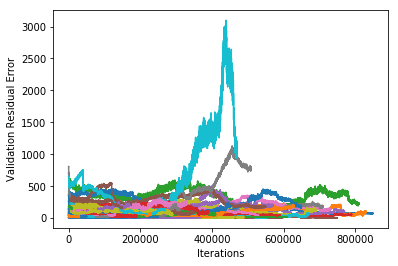

850000 163337500 33.218643 163.379791
851000 163337500 28.449371 160.028564
852000 163337500 6.127426 159.492584
853000 163337500 75.795326 157.694077
854000 163337500 28.900461 140.751144
855000 163337500 57.926746 147.385406
856000 163337500 74.071663 146.685043
857000 163337500 169.330795 149.955261
858000 163337500 15.269544 160.653854
859000 163337500 54.942791 155.429611


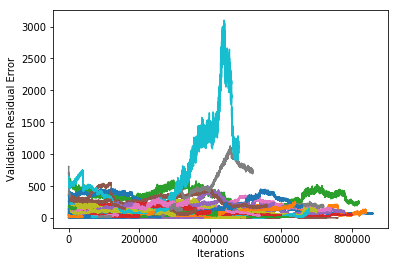

Generating new rollouts
(7376, 9) (878, 9)
(7376,) (878,)
(7376, 2) (878, 2)
(7376,) (878,)
860000 163337500 10.092580 27.635221
861000 163337500 66.912086 24.978176
862000 163337500 12.742442 21.692743
863000 163337500 28.216944 16.560450
864000 163337500 9.061573 15.471801
865000 163337500 46.857647 15.864992
866000 163337500 5.389085 22.973116
867000 163337500 50.951572 12.067838
868000 163337500 46.633591 16.880728
869000 163337500 78.833458 21.755295


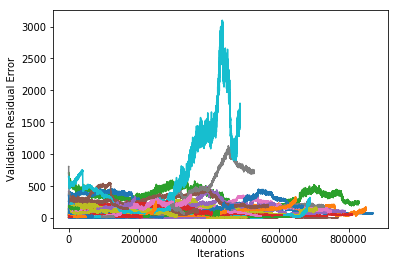

870000 163337500 39.907993 14.755979
871000 163337500 24.326492 13.231462
872000 163337500 7.221516 15.435473
873000 163337500 6.010735 11.271045
874000 163337500 35.174129 14.017464
875000 163337500 26.953146 10.772202
876000 163337500 12.221814 11.066155
877000 163337500 12.910167 10.907272
878000 163337500 10.115185 10.433654
879000 163337500 10.592553 10.129292


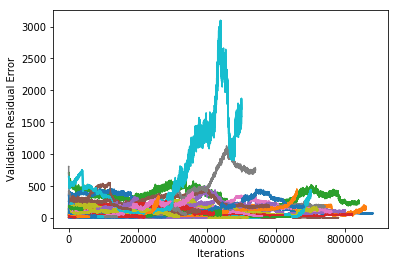

Generating new rollouts
(7376, 9) (768, 9)
(7376,) (768,)
(7376, 2) (768, 2)
(7376,) (768,)
880000 163337500 62.785816 17.158991
881000 163337500 93.396156 14.919759
882000 163337500 34.922459 15.219442
883000 163337500 30.982679 13.624506
884000 163337500 12.460381 12.957674
885000 163337500 16.122629 11.990276
886000 163337500 11.000965 12.798154
887000 163337500 7.560348 12.741607
888000 163337500 5.730066 11.553705
889000 163337500 27.185427 11.428718


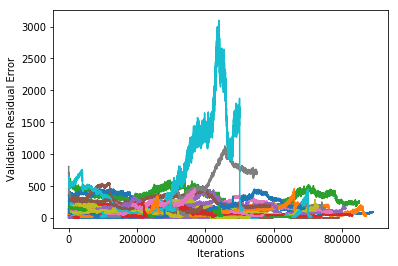

890000 163337500 69.456619 10.675605
891000 163337500 17.994444 10.357723
892000 163337500 18.848791 10.373309
893000 163337500 39.533367 9.837447
894000 163337500 14.058929 10.034997
895000 163337500 79.036987 9.027169
896000 163337500 51.427608 8.891699
897000 163337500 19.709291 9.292356
898000 163337500 80.132767 9.182754
899000 163337500 10.708224 8.879652


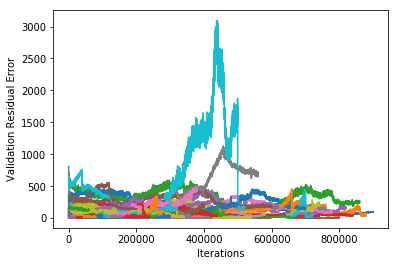

Generating new rollouts
(7376, 9) (759, 9)
(7376,) (759,)
(7376, 2) (759, 2)
(7376,) (759,)
900000 163337500 100.273643 294.457275
901000 163337500 33.854618 266.016968
902000 163337500 24.977432 249.344818
903000 163337500 9.436423 248.093170
904000 163337500 6.061018 235.895859
905000 163337500 31.020287 228.347473
906000 163337500 69.899498 238.105682
907000 163337500 50.121552 225.659393
908000 163337500 8.894020 223.218735
909000 163337500 43.084682 242.733673


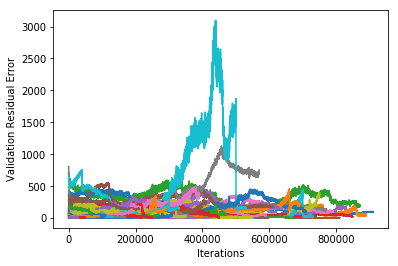

910000 163337500 152.471298 250.699203
911000 163337500 40.375427 254.375748
912000 163337500 41.185978 246.400055
913000 163337500 51.050385 239.919785
914000 163337500 144.009323 240.305511
915000 163337500 14.394046 235.647537
916000 163337500 54.141796 257.401917
917000 163337500 25.076599 261.660675
918000 163337500 100.725525 261.577667
919000 163337500 7.247664 245.830841


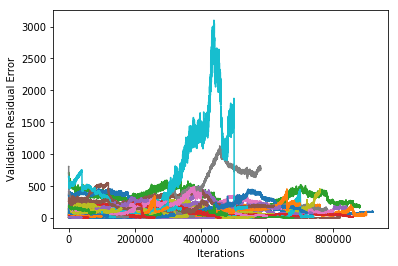

Generating new rollouts
(7376, 9) (715, 9)
(7376,) (715,)
(7376, 2) (715, 2)
(7376,) (715,)
920000 163337500 86.690315 328.859100
921000 163337500 108.466209 275.343628
922000 163337500 92.161537 235.351593
923000 163337500 6.489960 224.892868
924000 163337500 37.635639 195.824677
925000 163337500 16.802963 192.252640
926000 163337500 198.094528 150.306961
927000 163337500 15.254936 150.589417
928000 163337500 15.973518 130.839752
929000 163337500 118.079979 123.544701


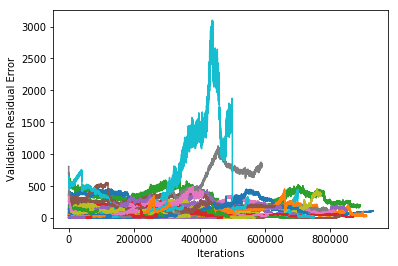

930000 163337500 99.905945 97.270508
931000 163337500 68.851585 102.131447
932000 163337500 39.067978 90.215073
933000 163337500 79.673546 93.918991
934000 163337500 6.195301 89.973900
935000 163337500 52.953770 89.808174
936000 163337500 9.768268 75.766853
937000 163337500 55.234699 87.135849
938000 163337500 15.585326 74.082840
939000 163337500 13.013099 81.170677


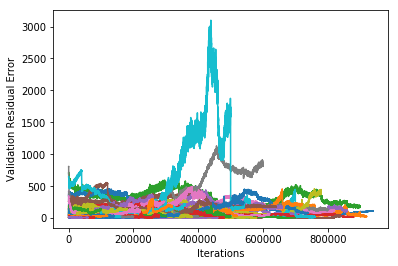

Generating new rollouts
(7376, 9) (762, 9)
(7376,) (762,)
(7376, 2) (762, 2)
(7376,) (762,)
940000 163337500 26.029470 93.893288
941000 163337500 12.529091 61.842010
942000 163337500 70.400429 58.821095
943000 163337500 49.813137 54.267609
944000 163337500 15.681886 53.095764
945000 163337500 119.554253 49.226128
946000 163337500 26.907028 47.019722
947000 163337500 25.463501 53.541054
948000 163337500 6.845788 50.865822
949000 163337500 26.047203 43.916969


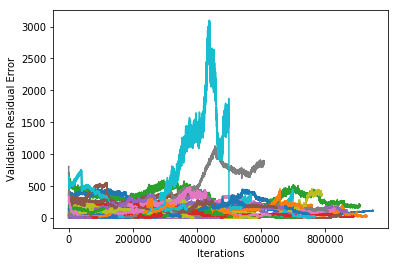

950000 163337500 16.169693 50.353710
951000 163337500 8.441335 39.199211
952000 163337500 125.682007 47.010189
953000 163337500 22.449808 40.611092
954000 163337500 11.149352 42.281712
955000 163337500 86.680885 46.110138
956000 163337500 9.043152 45.897827
957000 163337500 6.367166 47.713173
958000 163337500 39.086243 43.875946
959000 163337500 35.463284 39.954575


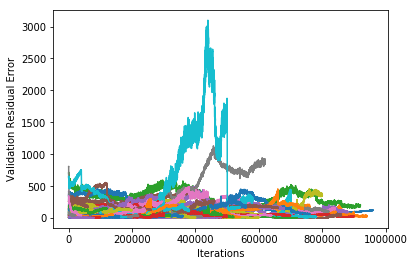

Generating new rollouts
(7376, 9) (827, 9)
(7376,) (827,)
(7376, 2) (827, 2)
(7376,) (827,)
960000 163337500 5.138535 468.809814
961000 163337500 6.366327 282.304901
962000 163337500 4.309855 233.829773
963000 163337500 20.745325 238.724442
964000 163337500 25.678282 238.468719
965000 163337500 12.567245 230.801682
966000 163337500 47.598515 229.960388
967000 163337500 12.551307 228.291672
968000 163337500 7.922389 230.078522
969000 163337500 43.115742 241.210846


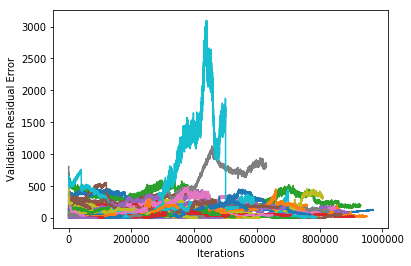

970000 163337500 19.843012 228.086075
971000 163337500 19.375589 230.967636
972000 163337500 65.306541 214.626297
973000 163337500 68.174858 202.603561
974000 163337500 15.114388 202.196304
975000 163337500 74.942070 194.659698
976000 163337500 66.859703 186.474762
977000 163337500 63.355621 184.366882
978000 163337500 25.719193 178.286346
979000 163337500 15.376462 185.835800


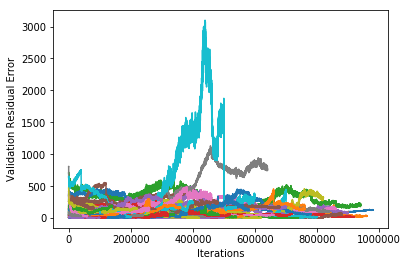

Generating new rollouts
(7376, 9) (849, 9)
(7376,) (849,)
(7376, 2) (849, 2)
(7376,) (849,)
980000 163337500 301.077789 360.590210
981000 163337500 45.125774 65.993317
982000 163337500 79.075195 54.551750
983000 163337500 15.520772 56.470600
984000 163337500 9.101554 39.864166
985000 163337500 5.161130 52.315807
986000 163337500 5.586260 46.709644
987000 163337500 88.925537 55.536427


KeyboardInterrupt: 

In [205]:
while len(soft_train_logs['err']) < max_iters:
  if len(soft_train_logs['err']) % dagger_iter_rate == 0 and len(soft_train_logs['err']) != 0:
    print("Generating new rollouts")
    new_train_cons, new_val_cons = sample_q_learn_constraints(train_id, dagger_constraint_sims, pol_q_t)
    n_new_cons = new_train_cons[0].shape[0]
    for i in range(len(train_constraints)):
        print(train_constraints[i].shape, new_train_cons[i].shape)
        if len(train_constraints[i].shape) == 2:
            train_constraints[i] = np.vstack((train_constraints[i], new_train_cons[i]))[n_new_cons:]
        else:
            train_constraints[i] = np.append(train_constraints[i], new_train_cons[i])[n_new_cons:]
    val_constraint_list += [new_val_cons]
    soft_train_logs['val_errs'] += [[]]
  constraint_batch = sample_q_learn_constraint_batch(constraint_batch_size)
  t = len(soft_train_logs['err'])
  err = compute_qbatch_loss(constraint_batch, train_update_op)
  if len(val_errs) == 0 or len(soft_train_logs['val_errs'][0]) % val_update_freq == 0:
    for i,val_cons in enumerate(val_constraint_list):
        val_err = compute_qbatch_loss(val_cons, train_update_op, step=False)
        soft_train_logs['val_errs'][i].append(val_err)

  if len(soft_train_logs['err']) % 1000 == 0:
      print('%d %d %f %f' % (t, n_iters, err, val_err))
  soft_train_logs['err'].append(err)
  if len(soft_train_logs['err']) % 10000 == 0:
    plt.xlabel('Iterations')
    plt.ylabel("Validation Residual Error")
    for val_err in soft_train_logs['val_errs']:
        plt.plot(val_err)
    plt.show()

In [203]:
def q_policy(obs):
    policy_action = tf.argmax(pol_q_t, axis=1)
    return sess.run([policy_action], feed_dict = {obs_t_ph : np.array([obs])})[0][0]


In [206]:
run_ep(q_policy, train_env, max_ep_len=max_ep_len, render=True, task_idx=None)
qlearn_env.close()

# MPC-R attempt [failed due to difficulties with contactlisteners]

In [102]:
obs_t_ph = tf.placeholder(tf.float32, [None, n_obs_feats], name="ot")
act_t_feats_ph = tf.placeholder(tf.float32, [None, n_act_feats], name="atf")

obs_tp1 = build_mlp(
  tf.concat((obs_t_ph, act_t_feats_ph), axis=1),
  n_obs_dim, invdyn_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [137]:
controller = MPCController(train_env, train_env.env._reward, obs_t_ph, act_t_feats_ph, obs_tp1, sess, 100, 50, gamma, n_act_dim, featurize_act)

In [138]:
def run_controller_ep(policy, env, max_ep_len=max_ep_len, render=False, task_idx=None):
  obs = env.reset()
  done = False
  totalr = 0.
  prev_obs = obs
  rollout = []
  for step_idx in range(max_ep_len+1):
    if done:
      break
    action = policy(obs, step_idx)
    obs, r, done, info = env.step(action)
    rollout.append((prev_obs, action, r, obs, float(done), task_idx))
    prev_obs = obs
    if render:
      env.render()
    totalr += r
  return rollout

In [164]:
%autoreload
run_controller_ep(controller.get_action, train_env, max_ep_len=max_ep_len, render=False, task_idx=None)

+++++++++++++TEST REWARD++++++++++++++
0.0 None 0.0 0.0 False False False
(-31.03001162124974, -31.03001162124974, 0.0, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
-95.62481566567733 -336.39292300986926
+++++++++++++TEST REWARD++++++++++++++
-1.4988692562473005 -1.2363692562473005 0.2625 0.0 False False False
(-1.5050959773846102, -1.2425959773846103, 0.2625, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
-169.08750362590536 -355.1787768733719
+++++++++++++TEST REWARD++++++++++++++
0.24511976512419778 0.5301197651241978 0.2625 0.0225 False False False
(0.24409172146101468, 0.5290917214610147, 0.2625, 0.0225, False, False)
++++++++++++++++++++++++++++++++++++++
-141.5432335392182 -365.3399913839655
+++++++++++++TEST REWARD++++++++++++++
-2.0448841137438025 -1.7823841137438023 0.2625 0.0 False False False
(-2.0346122439620844, -1.7721122439620842, 0.2625, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
-52.31252826338086 -354.09107300854043
++++++++++++

-17.747758871866353 -65.89482846748975
+++++++++++++TEST REWARD++++++++++++++
-4.258620907230693 -4.258620907230693 0.0 0.0 False False False
(-4.544996207259146, -4.544996207259146, 0.0, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
-8.040511787217916 -86.72305286886167
+++++++++++++TEST REWARD++++++++++++++
-4.225330710207686 -4.225330710207686 0.0 0.0 False False False
(-4.537354341349783, -4.537354341349783, 0.0, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
-1.1271674732865846 -66.2387345319106
+++++++++++++TEST REWARD++++++++++++++
-4.213424339818508 -4.190924339818508 0.0 0.0225 False False False
(-4.55316820282163, -4.53066820282163, 0.0, 0.0225, False, False)
++++++++++++++++++++++++++++++++++++++
0.3167260742439262 -69.02239409568764
+++++++++++++TEST REWARD++++++++++++++
-4.309803183401576 -4.287303183401576 0.0 0.0225 False False False
(-4.674363156638342, -4.651863156638342, 0.0, 0.0225, False, False)
++++++++++++++++++++++++++++++++++++++
9.0105346

65.89283580894381 35.3864685203881
+++++++++++++TEST REWARD++++++++++++++
1.0015037145152201 1.28650371451522 0.2625 0.0225 False False False
(0.2162475175294071, 0.5012475175294071, 0.2625, 0.0225, False, False)
++++++++++++++++++++++++++++++++++++++
68.30916668204176 28.831035062846254
+++++++++++++TEST REWARD++++++++++++++
-2.817590795384035 -2.817590795384035 0.0 0.0 False False False
(-3.6328268814278886, -3.6328268814278886, 0.0, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
82.58933919155095 43.899159225090116
+++++++++++++TEST REWARD++++++++++++++
-2.7916176687850225 -2.7916176687850225 0.0 0.0 False False False
(-3.635257727060093, -3.635257727060093, 0.0, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
77.64072192447759 48.21402646289373
+++++++++++++TEST REWARD++++++++++++++
2.0872575949120913 2.3497575949120915 0.2625 0.0 False False False
(1.2403331924069676, 1.5028331924069676, 0.2625, 0.0, False, False)
++++++++++++++++++++++++++++++++++++++
84.0720

[(array([-0.00288639,  0.93919793, -0.29236376, -0.09436676,  0.00335129,
          0.06622471,  0.        ,  0.        ,  0.2       ]),
  4,
  -1.4988692562473005,
  array([-0.00591631,  0.93790122, -0.30561286, -0.08645974,  0.00594574,
          0.05189538,  0.        ,  0.        ,  0.2       ]),
  0.0,
  None),
 (array([-0.00591631,  0.93790122, -0.30561286, -0.08645974,  0.00594574,
          0.05189538,  0.        ,  0.        ,  0.2       ]),
  3,
  0.24511976512419778,
  array([-0.00885096,  0.93675757, -0.29835331, -0.0762665 ,  0.01078782,
          0.09685285,  0.        ,  0.        ,  0.2       ]),
  0.0,
  None),
 (array([-0.00885096,  0.93675757, -0.29835331, -0.0762665 ,  0.01078782,
          0.09685285,  0.        ,  0.        ,  0.2       ]),
  4,
  -2.0448841137438025,
  array([-0.01197033,  0.9358286 , -0.31597635, -0.06196299,  0.01478644,
          0.07998155,  0.        ,  0.        ,  0.2       ]),
  0.0,
  None),
 (array([-0.01197033,  0.9358286 , -0.31597635

In [140]:
train_env.close()

In [136]:
import cProfile

def do_cprofile(func):
    def profiled_func(*args, **kwargs):
        profile = cProfile.Profile()
        try:
            profile.enable()
            result = func(*args, **kwargs)
            profile.disable()
            return result
        finally:
            profile.print_stats()
    return profiled_func


profiled_run_ep = do_cprofile(run_controller_ep)

In [141]:
profiled_run_ep(controller.get_action, train_env, max_ep_len=max_ep_len, render=True, task_idx=None)

         10112590 function calls (10074090 primitive calls) in 28.264 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    37532    0.021    0.000    0.034    0.000 <frozen importlib._bootstrap>:997(_handle_fromlist)
   385078    0.501    0.000    0.923    0.000 <ipython-input-10-5df4dd7258a8>:2(disc_to_cont)
        1    0.001    0.001   28.267   28.267 <ipython-input-133-e02781be3f4d>:1(run_controller_ep)
       78    0.000    0.000    0.020    0.000 <ipython-input-15-6408536dbf80>:6(step)
     7700    0.014    0.000    1.096    0.000 <ipython-input-46-0e50c9feffc4>:4(<lambda>)
     7700    0.159    0.000    1.082    0.000 <ipython-input-46-0e50c9feffc4>:4(<listcomp>)
     7700    0.007    0.000    0.015    0.000 <string>:12(__new__)
      289    0.001    0.000    0.002    0.000 Box2D.py:143(_init_kwargs)
        2    0.000    0.000    0.000    0.000 Box2D.py:157(_init_jointdef_kwargs)
       84    0.000    0.000    0.001 

[(array([-0.00498695,  0.93660155, -0.50514525, -0.26746438,  0.00578548,
          0.11442284,  0.        ,  0.        , -0.4       ]),
  4,
  1.4312225769325722,
  array([-0.00986137,  0.93283997, -0.49372885, -0.25081031,  0.01200691,
          0.12444408,  0.        ,  0.        , -0.4       ]),
  0.0,
  None),
 (array([-0.00986137,  0.93283997, -0.49372885, -0.25081031,  0.01200691,
          0.12444408,  0.        ,  0.        , -0.4       ]),
  1,
  -2.0402874052200843,
  array([-0.01473598,  0.92845336, -0.49375263, -0.29250483,  0.0182243 ,
          0.12436231,  0.        ,  0.        , -0.4       ]),
  0.0,
  None),
 (array([-0.01473598,  0.92845336, -0.49375263, -0.29250483,  0.0182243 ,
          0.12436231,  0.        ,  0.        , -0.4       ]),
  5,
  2.713329606034076,
  array([-0.0194087 ,  0.92437449, -0.47201404, -0.27199133,  0.02291436,
          0.09381229,  0.        ,  0.        , -0.4       ]),
  0.0,
  None),
 (array([-0.0194087 ,  0.92437449, -0.47201404, -

In [142]:
train_env.close()

In [147]:
from line_profiler import LineProfiler

def do_profile(follow=[]):
    def inner(func):
        def profiled_func(*args, **kwargs):
            try:
                profiler = LineProfiler()
                profiler.add_function(func)
                for f in follow:
                    profiler.add_function(f)
                profiler.enable_by_count()
                return func(*args, **kwargs)
            finally:
                profiler.print_stats()
        return profiled_func
    return inner


In [148]:
@do_profile(follow=[train_env.env._reward,controller.get_action])
def lp_run_controller_ep(policy, env, max_ep_len=max_ep_len, render=False, task_idx=None):
  obs = env.reset()
  done = False
  totalr = 0.
  prev_obs = obs
  rollout = []
  for step_idx in range(max_ep_len+1):
    if done:
      break
    action = policy(obs, step_idx)
    obs, r, done, info = env.step(action)
    rollout.append((prev_obs, action, r, obs, float(done), task_idx))
    prev_obs = obs
    if render:
      env.render()
    totalr += r
  return rollout

In [150]:
lp_run_controller_ep(controller.get_action, train_env, max_ep_len=max_ep_len, render=False, task_idx=None)

Timer unit: 1e-06 s

Total time: 53.7616 s
File: /Users/mckaneandrus/Masters Research/IRLD/IRLD/nn_dynamics/mpc_controller.py
Function: get_action at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                               def get_action(self, curr_state, curr_step, return_score=False):
    38                                                   # randomly sample N candidate action sequences
    39        83         79.0      1.0      0.0          if self.discrete_acts:
    40        83       5628.0     67.8      0.0              all_samples = npr.randint(0, self.n_acts, (self.N, self.horizon))
    41                                                   else:
    42                                                       all_samples = npr.uniform(self.env.action_space.low, self.env.action_space.high,
    43                                                                                 (self.N, self.horizon, self.env.action_space.shape[0]))
 

[(array([ 0.00422745,  0.93758221,  0.4281823 , -0.20209072, -0.00489181,
         -0.09698971,  0.        ,  0.        ,  0.2       ]),
  0,
  -1.0368679568608092,
  array([ 0.00839338,  0.93394709,  0.4198603 , -0.24235286, -0.00813071,
         -0.06478466,  0.        ,  0.        ,  0.2       ]),
  0.0,
  None),
 (array([ 0.00839338,  0.93394709,  0.4198603 , -0.24235286, -0.00813071,
         -0.06478466,  0.        ,  0.        ,  0.2       ]),
  0,
  -0.9848548236415331,
  array([ 0.01247549,  0.9296856 ,  0.40934163, -0.28410657, -0.00925597,
         -0.0225076 ,  0.        ,  0.        ,  0.2       ]),
  0.0,
  None),
 (array([ 0.01247549,  0.9296856 ,  0.40934163, -0.28410657, -0.00925597,
         -0.0225076 ,  0.        ,  0.        ,  0.2       ]),
  4,
  1.632964663482187,
  array([ 0.01646624,  0.92565499,  0.40068904, -0.26871838, -0.01085704,
         -0.03202511,  0.        ,  0.        ,  0.2       ]),
  0.0,
  None),
 (array([ 0.01646624,  0.92565499,  0.40068904, 